# COMP1801 - Machine Learning Coursework Solution

Let’s start by importing the essential Python libraries for data analysis and machine learning.

In [45]:
# Import libraries
try:
    import glob
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Importing libraries for model building
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Ridge
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score

    from statsmodels.stats.outliers_influence import variance_inflation_factor

except Exception as e:
    print(f"Error : {e}")

In [46]:
# Find the CSV file in the Datasets directory
data_path = '../Datasets/*.csv'
file_list = glob.glob(data_path)

for file in file_list:
    print(f"Found file: {file}")

# Ensure there is exactly one file
if len(file_list) == 1:
    # Load the dataset
    df = pd.read_csv(file_list[0])
    print(f"Loaded dataset: {file_list[0]}")
else:
    raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")

Found file: ../Datasets/Dataset.csv
Loaded dataset: ../Datasets/Dataset.csv


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lifespan        1000 non-null   float64
 1   partType        1000 non-null   object 
 2   microstructure  1000 non-null   object 
 3   coolingRate     1000 non-null   int64  
 4   quenchTime      1000 non-null   float64
 5   forgeTime       1000 non-null   float64
 6   HeatTreatTime   1000 non-null   float64
 7   Nickel%         1000 non-null   float64
 8   Iron%           1000 non-null   float64
 9   Cobalt%         1000 non-null   float64
 10  Chromium%       1000 non-null   float64
 11  smallDefects    1000 non-null   int64  
 12  largeDefects    1000 non-null   int64  
 13  sliverDefects   1000 non-null   int64  
 14  seedLocation    1000 non-null   object 
 15  castType        1000 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 125.1+ KB


In [48]:
# Check for missing values
df.isnull().sum()

Lifespan          0
partType          0
microstructure    0
coolingRate       0
quenchTime        0
forgeTime         0
HeatTreatTime     0
Nickel%           0
Iron%             0
Cobalt%           0
Chromium%         0
smallDefects      0
largeDefects      0
sliverDefects     0
seedLocation      0
castType          0
dtype: int64

In [49]:
df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die


In [50]:
df.describe()

,Lifespan,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1298.556320,17.639000,2.764230,5.464600,30.194510,60.243080,24.553580,12.434690,2.768650,17.311000,0.550000,0.292000
std,340.071434,7.491783,1.316979,2.604513,16.889415,5.790475,7.371737,4.333197,1.326496,12.268365,1.163982,1.199239
min,417.990000,5.000000,0.500000,1.030000,1.030000,50.020000,6.660000,5.020000,0.510000,0.000000,0.000000,0.000000
25%,1047.257500,11.000000,1.640000,3.170000,16.185000,55.287500,19.387500,8.597500,1.590000,7.000000,0.000000,0.000000
50%,1266.040000,18.000000,2.755000,5.475000,29.365000,60.615000,24.690000,12.585000,2.865000,18.000000,0.000000,0.000000
75%,1563.050000,24.000000,3.970000,7.740000,44.955000,65.220000,29.882500,16.080000,3.922500,26.000000,0.000000,0.000000
max,2134.530000,30.000000,4.990000,10.000000,59.910000,69.950000,43.650000,19.990000,4.990000,61.000000,4.000000,8.000000


In [51]:
# Using nunique()
num_parts = df['partType'].nunique()
print(f"Number of unique parts types: {num_parts}")

# Or using value_counts() to see the distribution
parts_distribution = df['partType'].value_counts()
print("\nDistribution of parts types:")
print(parts_distribution)

Number of unique parts types: 4

Distribution of parts types:
partType
Valve     265
Block     253
Nozzle    245
Blade     237
Name: count, dtype: int64


---

## Distribution of Lifespan

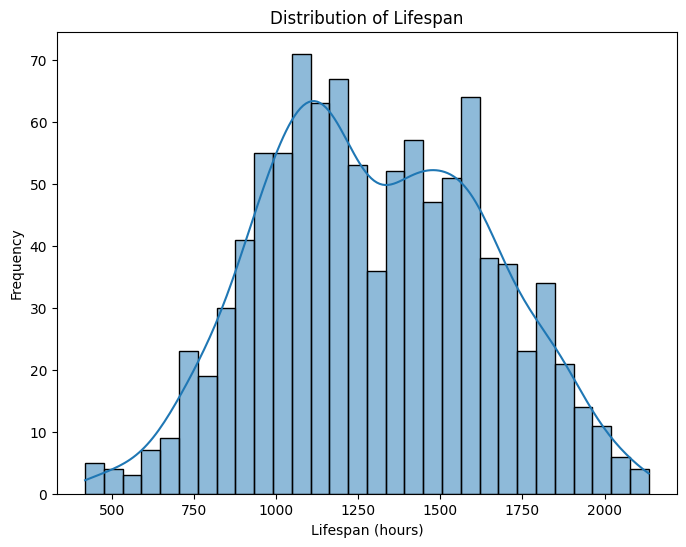

In [52]:
# Plotting the distribution of 'Lifespan'
plt.figure(figsize=(8, 6))
sns.histplot(df['Lifespan'], bins=30, kde=True)
plt.title('Distribution of Lifespan')
plt.xlabel('Lifespan (hours)')
plt.ylabel('Frequency')
plt.show()

## Distribution of Lifespan Between Different Metal Parts

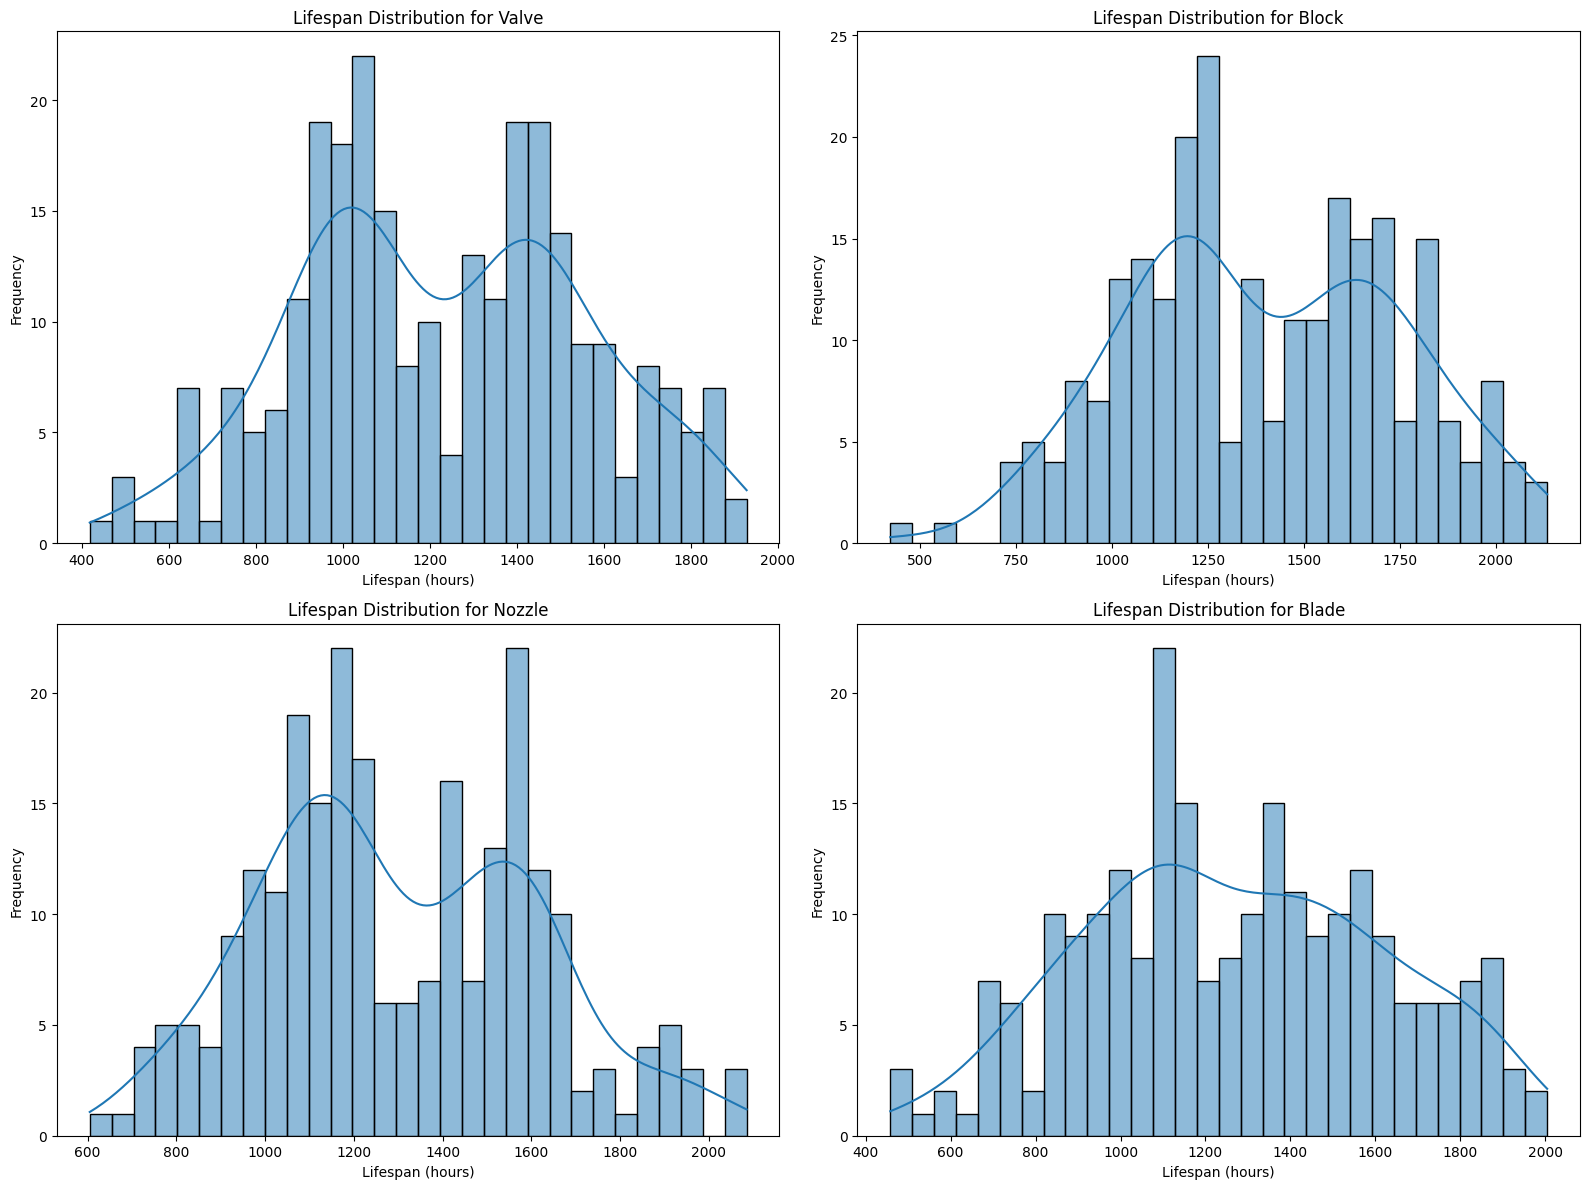

In [53]:
# List of metal parts
part_types = ['Valve', 'Block', 'Nozzle', 'Blade']

# Set up the subplots: 2 rows and 2 columns (one for each metal part)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop through each metal part and create a histogram for its lifespan distribution
for i, part in enumerate(part_types):
    subset = df[df['partType'] == part]
    sns.histplot(subset['Lifespan'], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Lifespan Distribution for {part}')
    axes[i].set_xlabel('Lifespan (hours)')
    axes[i].set_ylabel('Frequency')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

---

## Scatter Plot Analysis of Lifespan

In [54]:
# List of numerical columns excluding 'Lifespan'
numerical_cols = ['coolingRate', 'quenchTime', 'forgeTime', 'HeatTreatTime',
                  'Nickel%', 'Iron%', 'Cobalt%', 'Chromium%',
                  'smallDefects', 'largeDefects', 'sliverDefects']

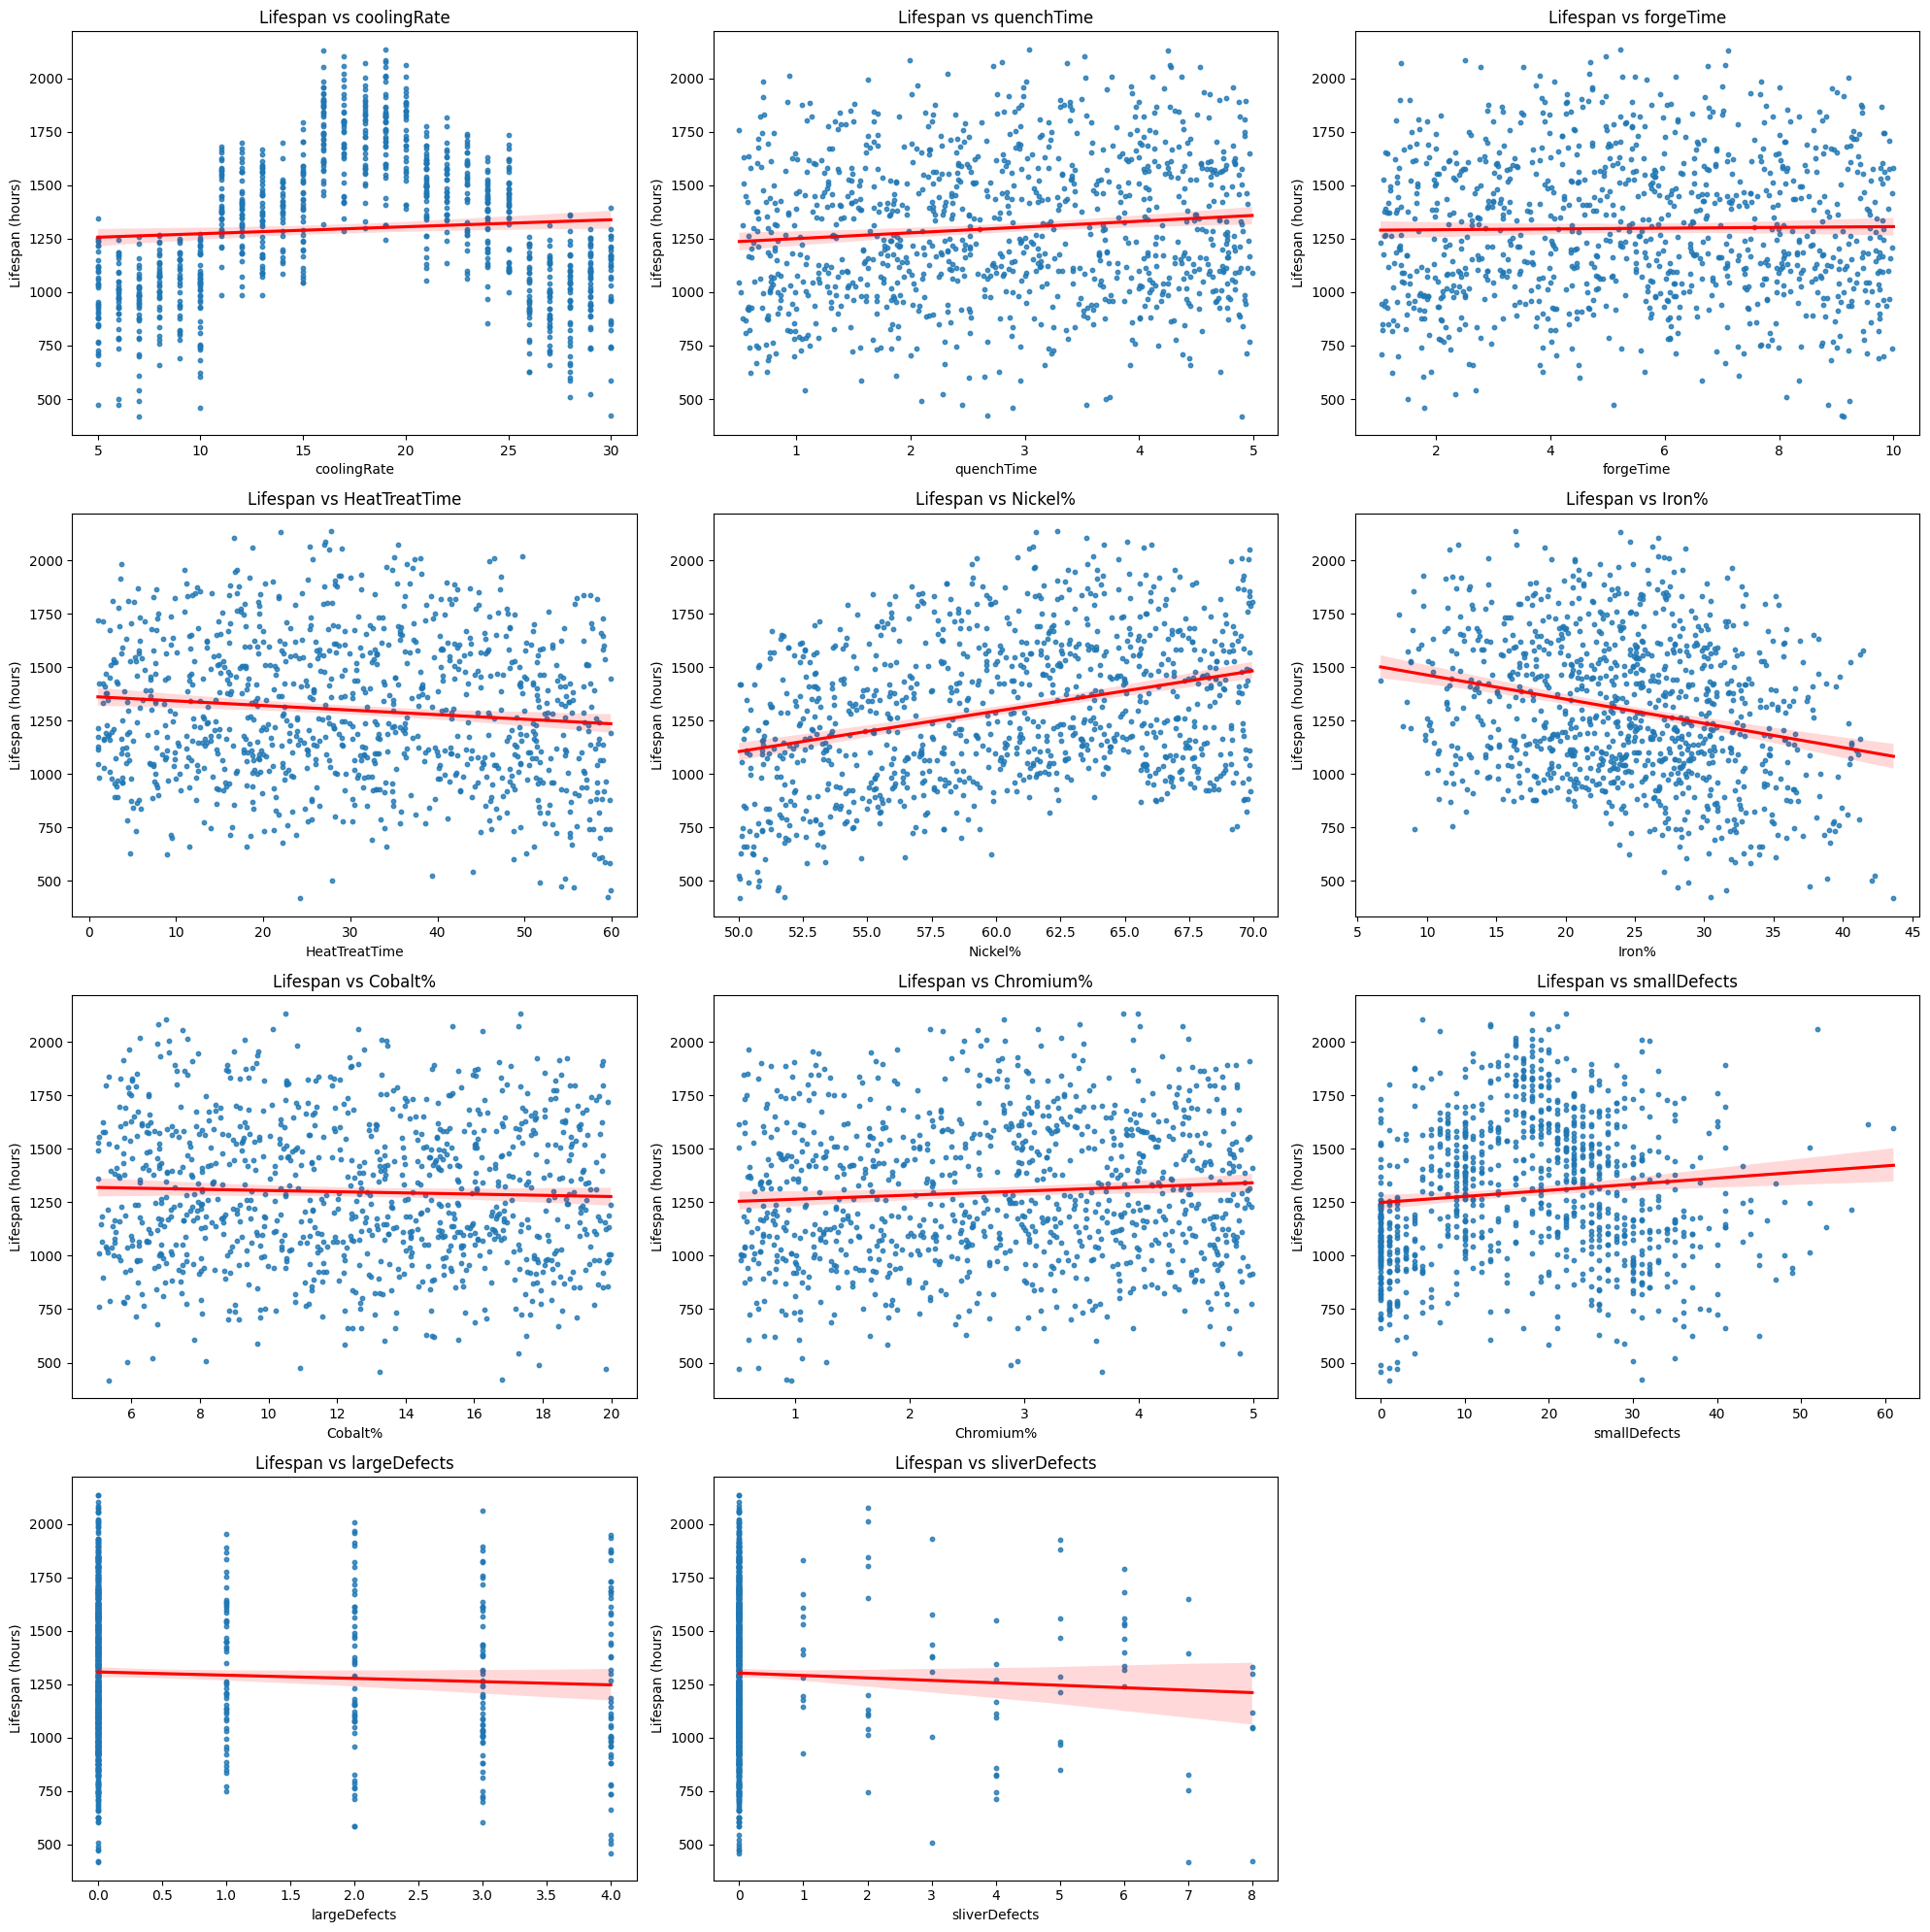

In [55]:
# Determine the number of rows and columns for the subplots
num_cols = len(numerical_cols)
nrows = num_cols // 3 + (num_cols % 3 > 0)  # Set up for 3 columns per row

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, nrows * 5))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot each scatterplot with a regression trend line in a different subplot
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=df, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')

# Remove any empty subplots if the number of features is not perfectly divisible by 3
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

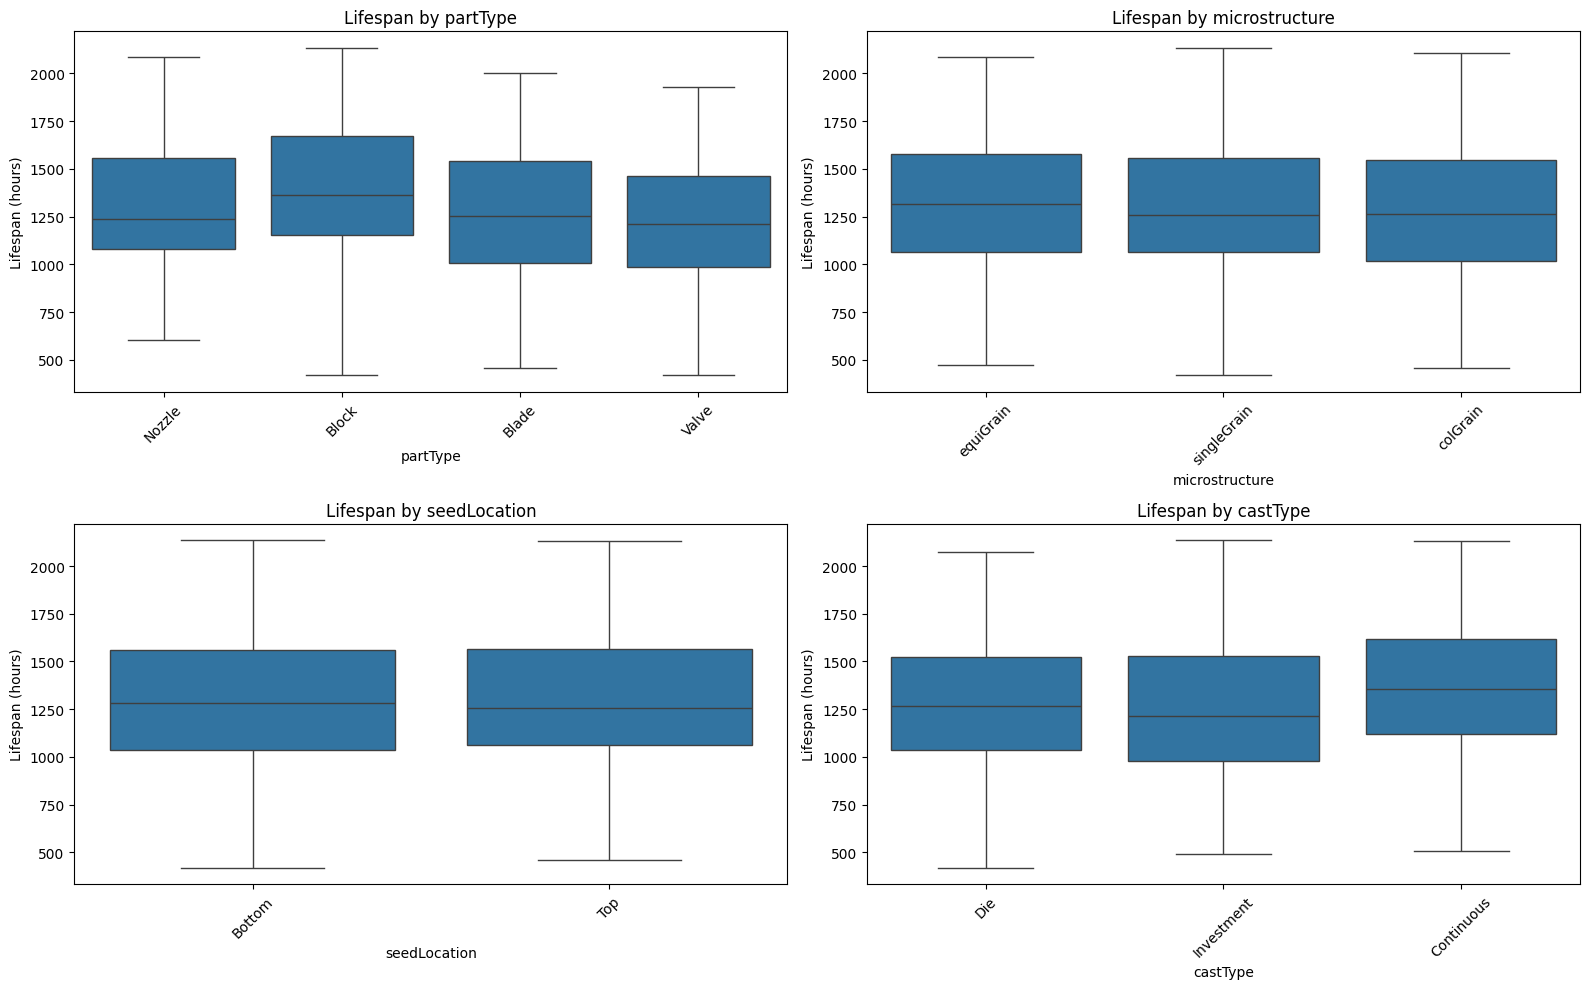

In [56]:
# List of categorical columns to include in the box plots
categorical_cols = ['partType', 'microstructure', 'seedLocation', 'castType']

# Determine the number of rows and columns for the subplots
num_cols = len(categorical_cols)
nrows = num_cols // 2 + (num_cols % 2 > 0)  # Set up for 2 columns per row for better readability

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(16, nrows * 5))
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Plot each boxplot in a different subplot
for i, col in enumerate(categorical_cols):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=df)
    axes[i].set_title(f'Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots if the number of features is odd
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


---

## Analysing the data based on Part Type

### Valve

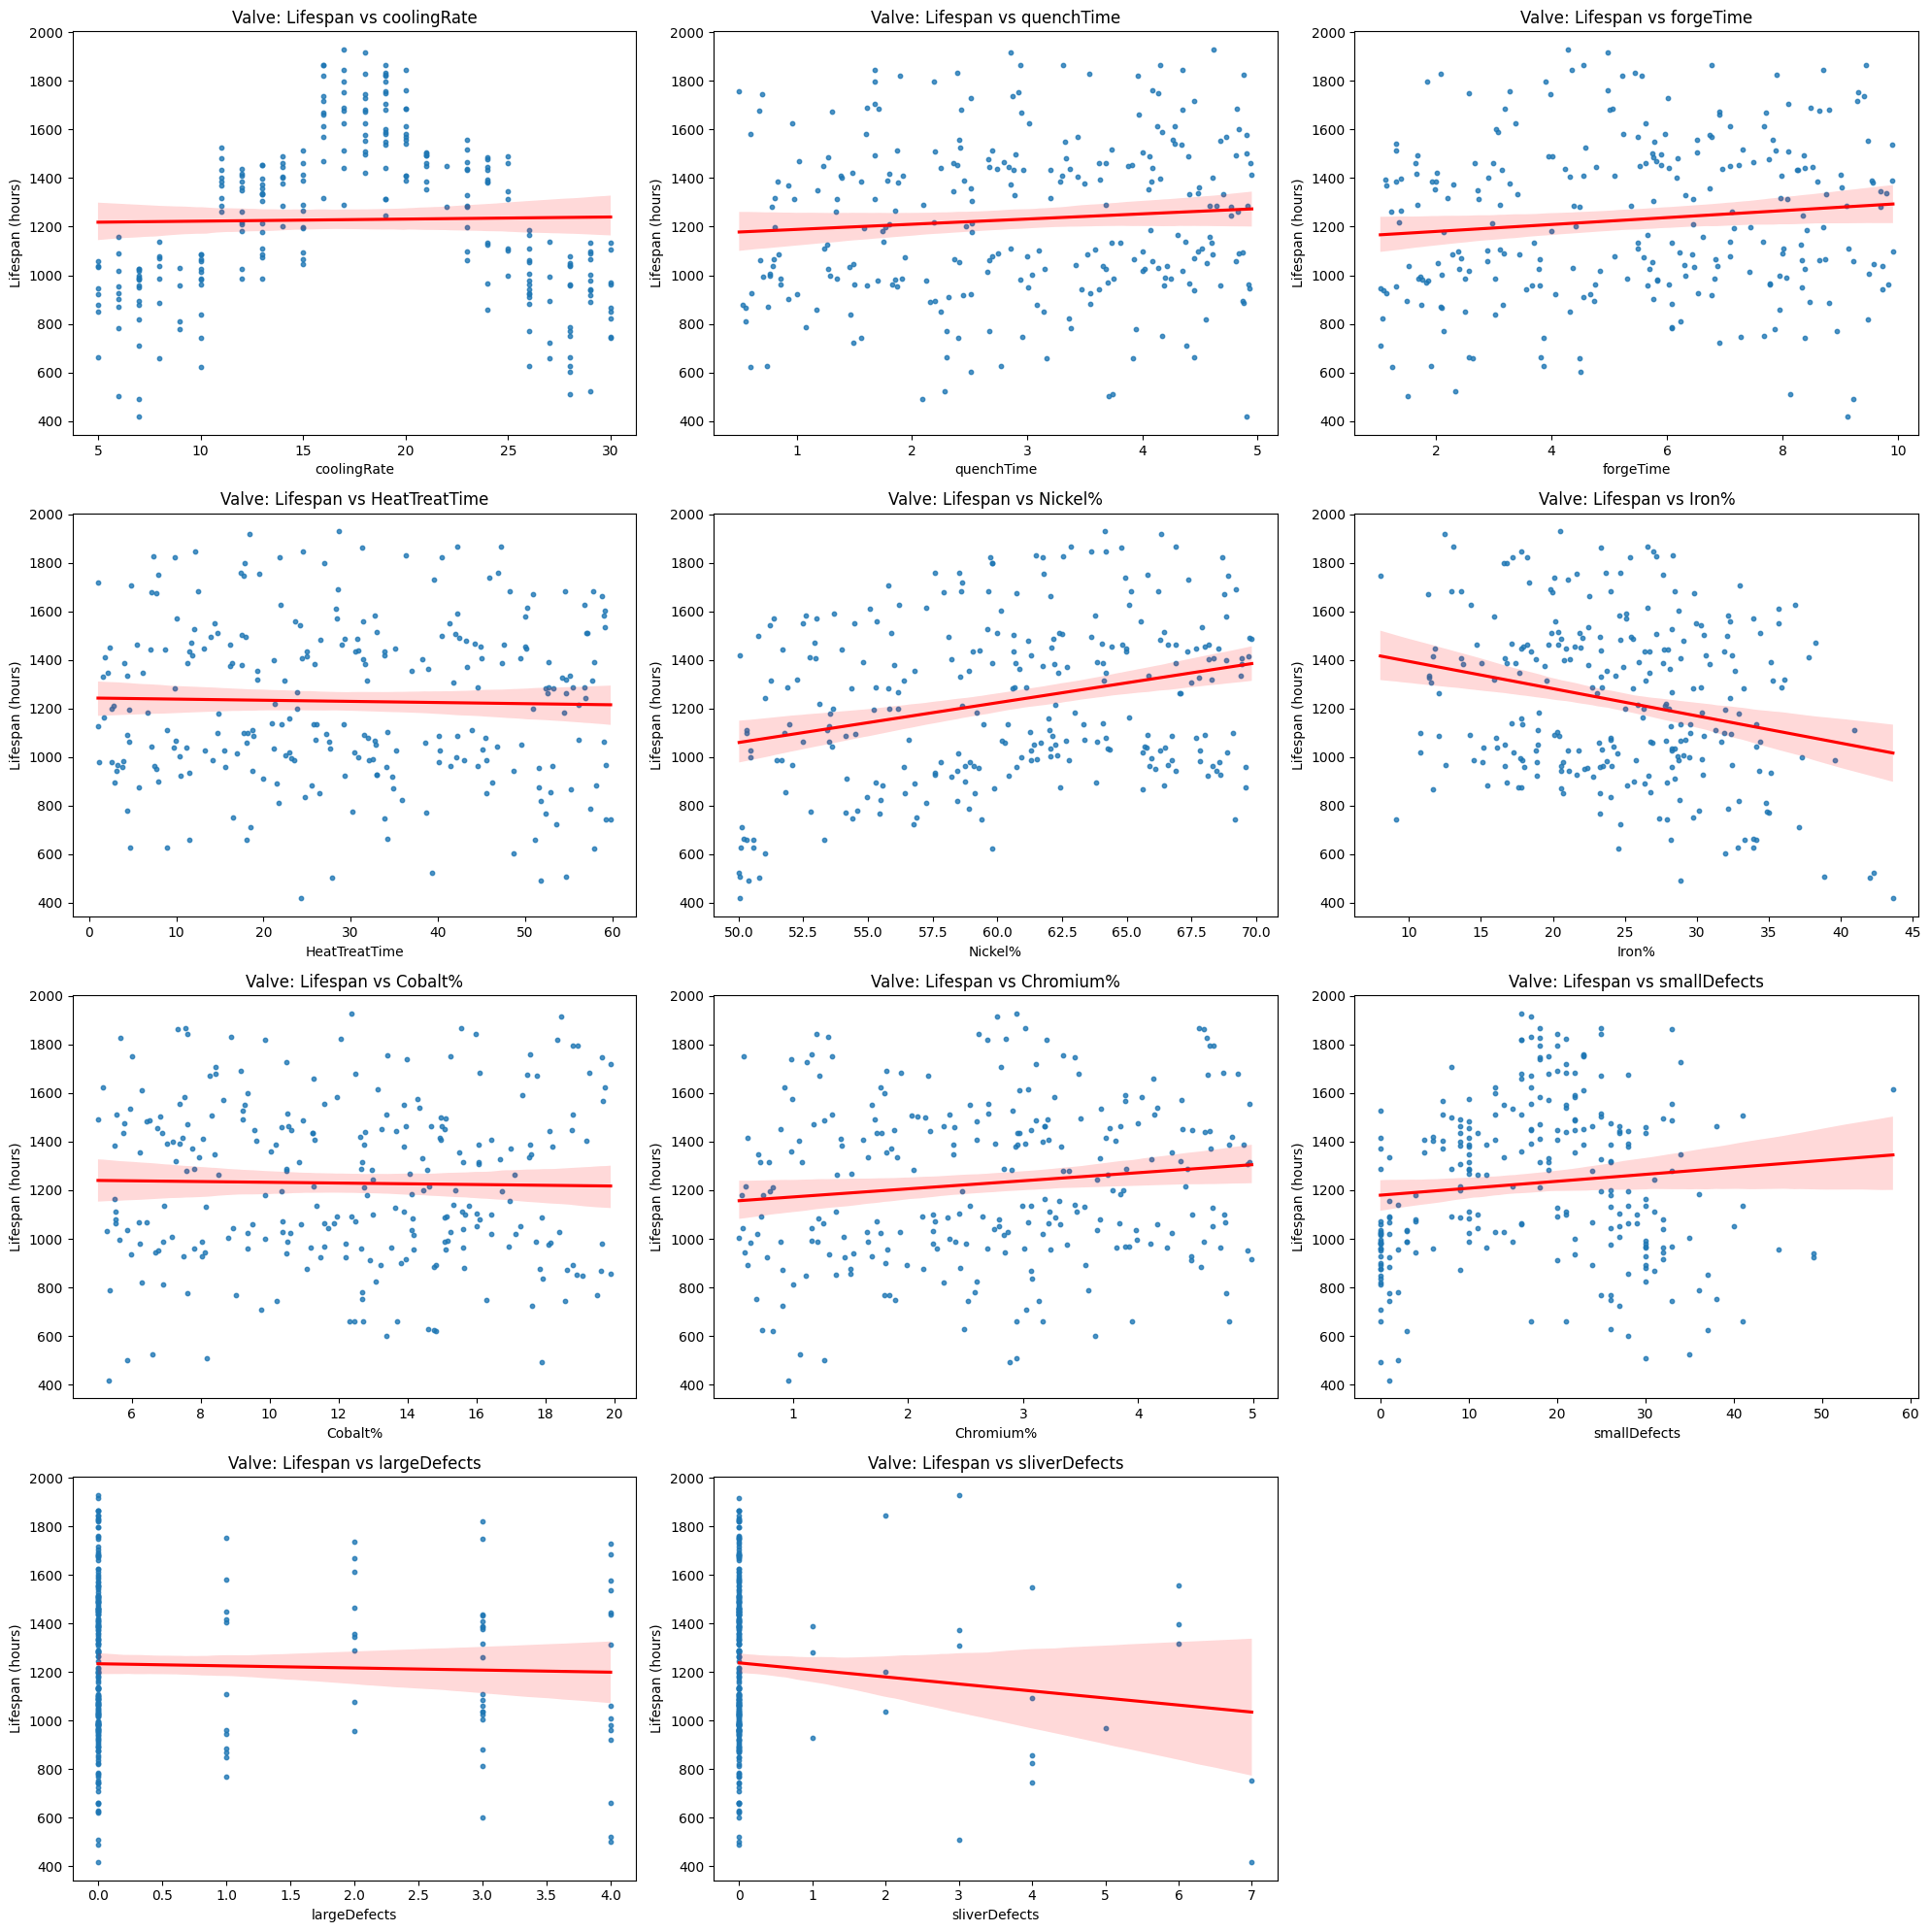

In [57]:
# 1. Scatter Plots for Valve
valve_data = df[df['partType'] == 'Valve']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=valve_data, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Valve: Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

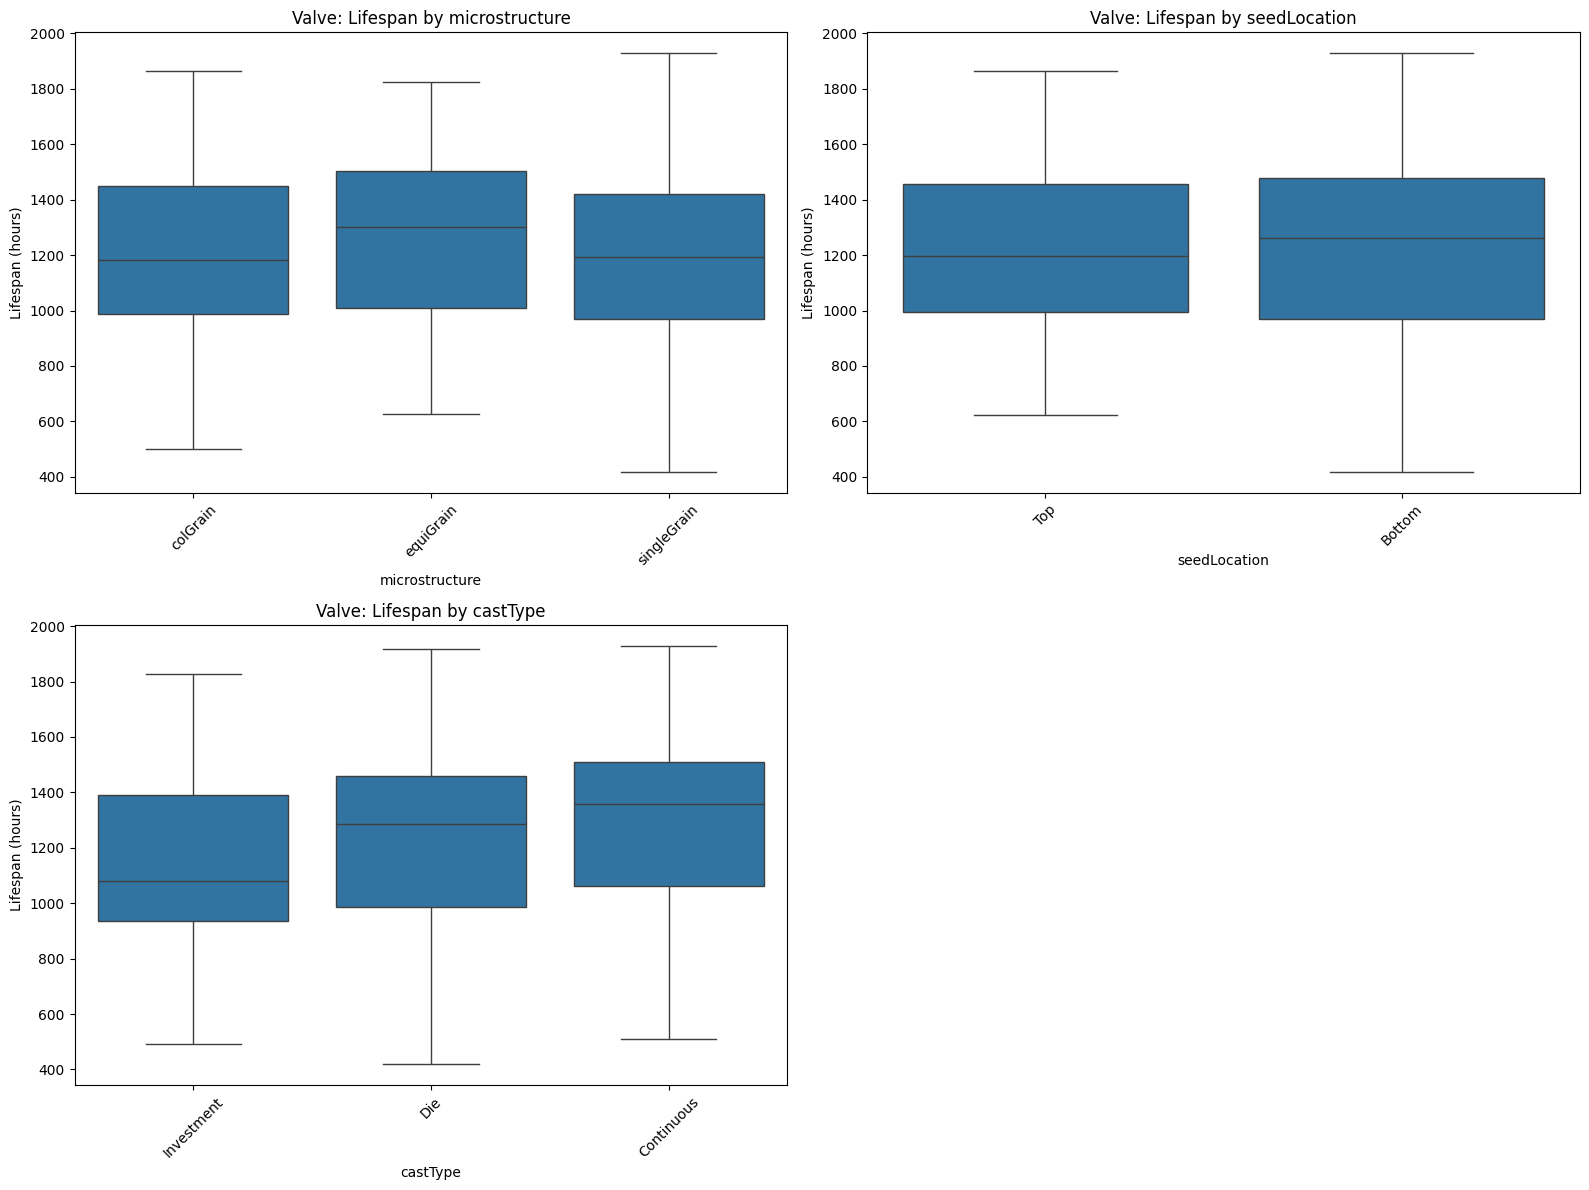

In [58]:
# 1. Box Plots for Valve
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(['microstructure', 'seedLocation', 'castType']):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=valve_data)
    axes[i].set_title(f'Valve: Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(['microstructure', 'seedLocation', 'castType']), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

---

### Block

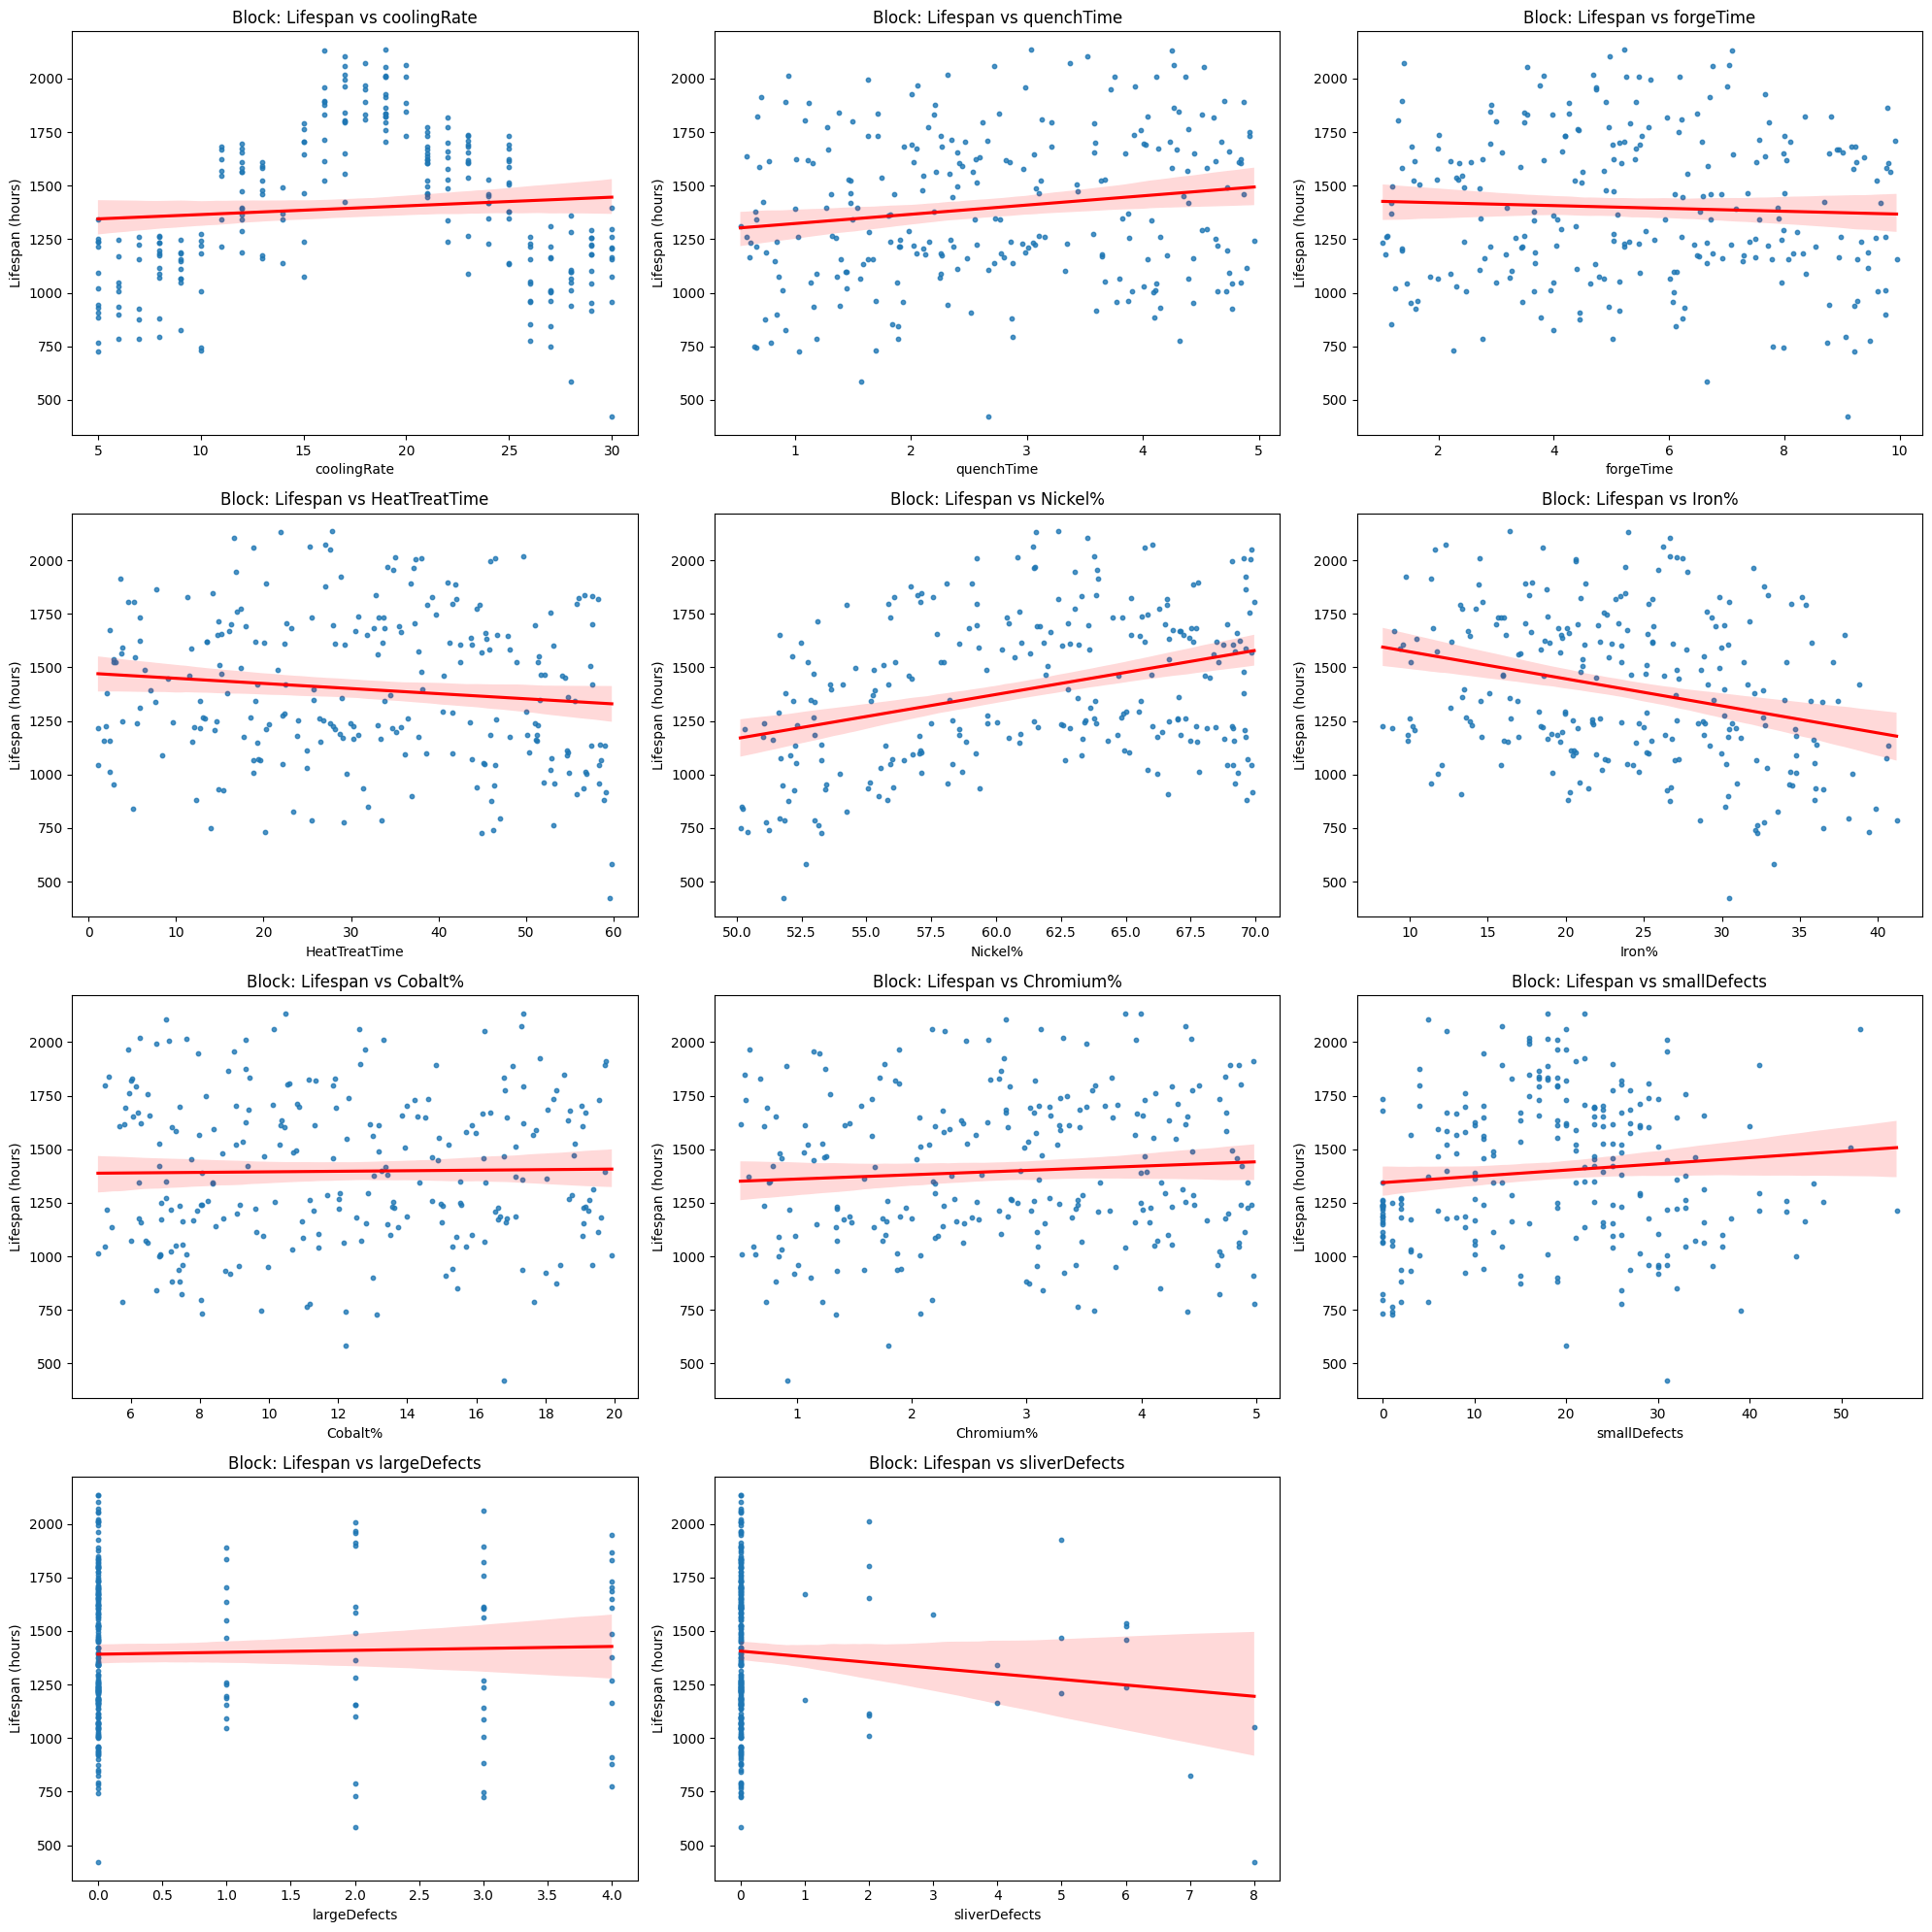

In [59]:
# 2. Scatter Plots for Block
block_data = df[df['partType'] == 'Block']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=block_data, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Block: Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

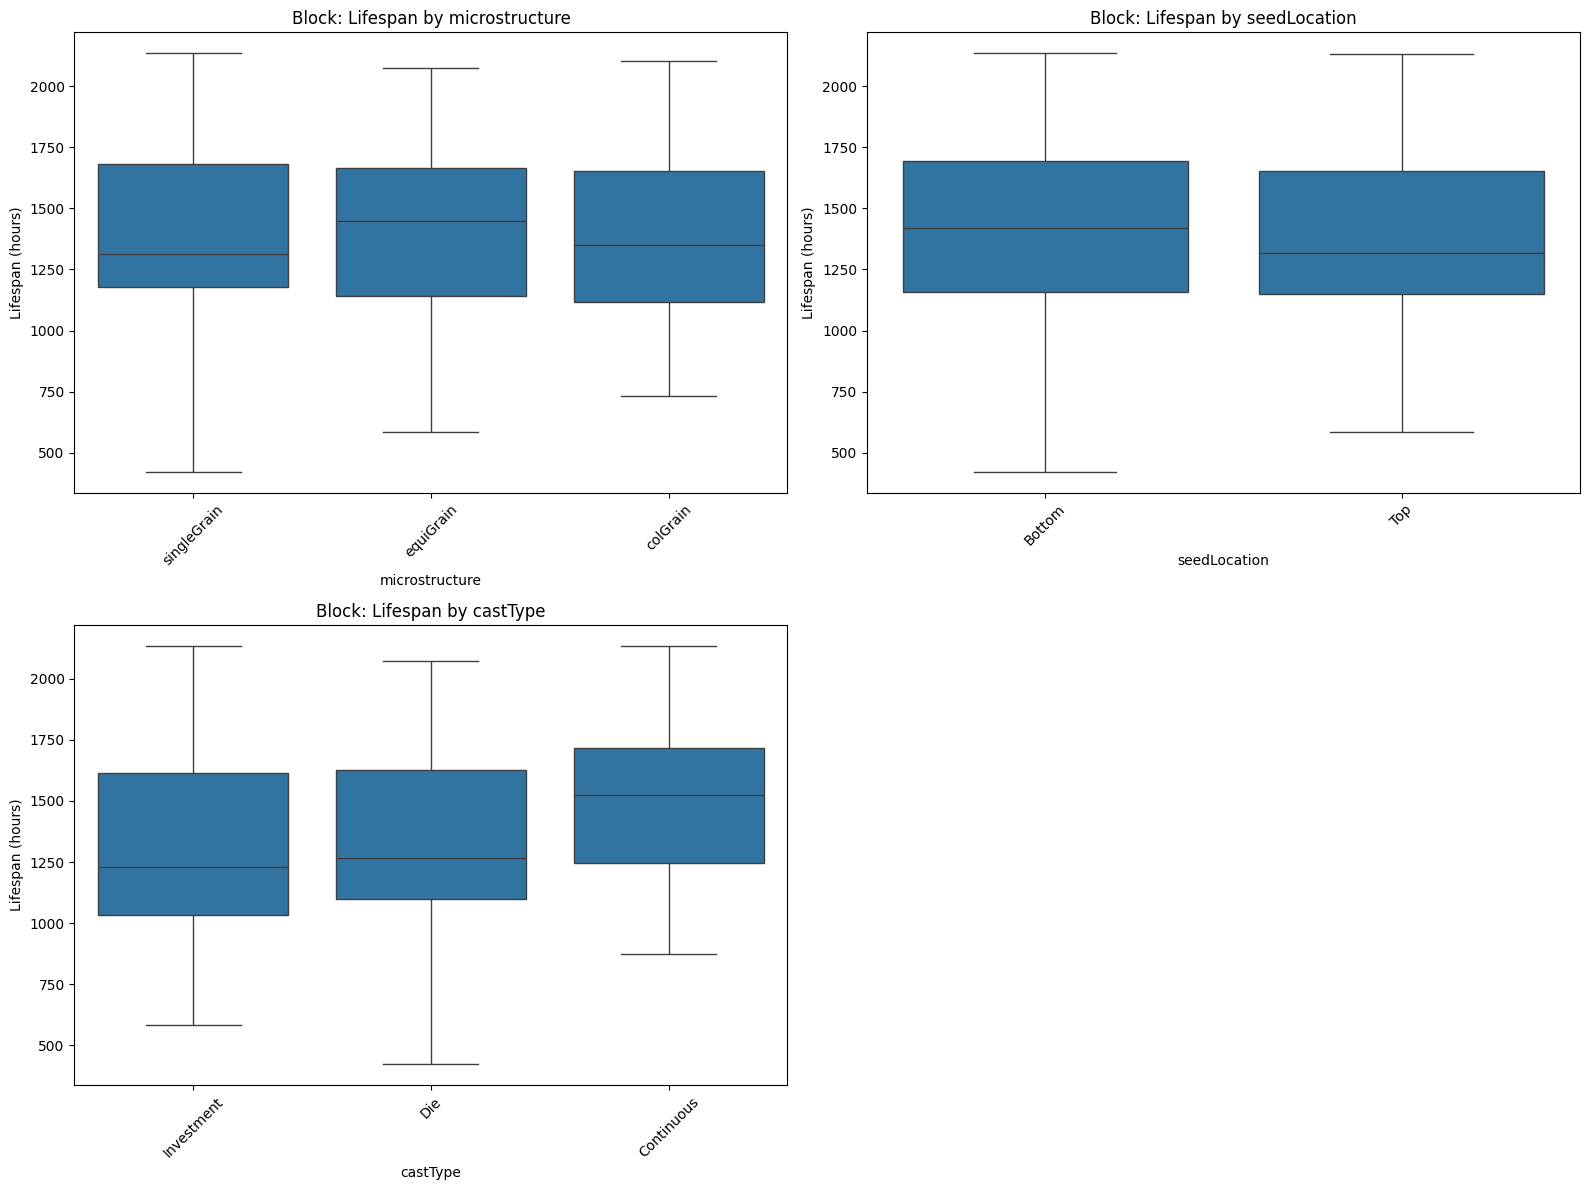

In [60]:
# 2. Box Plots for Block
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(['microstructure', 'seedLocation', 'castType']):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=block_data)
    axes[i].set_title(f'Block: Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(['microstructure', 'seedLocation', 'castType']), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

---

### Nozzle

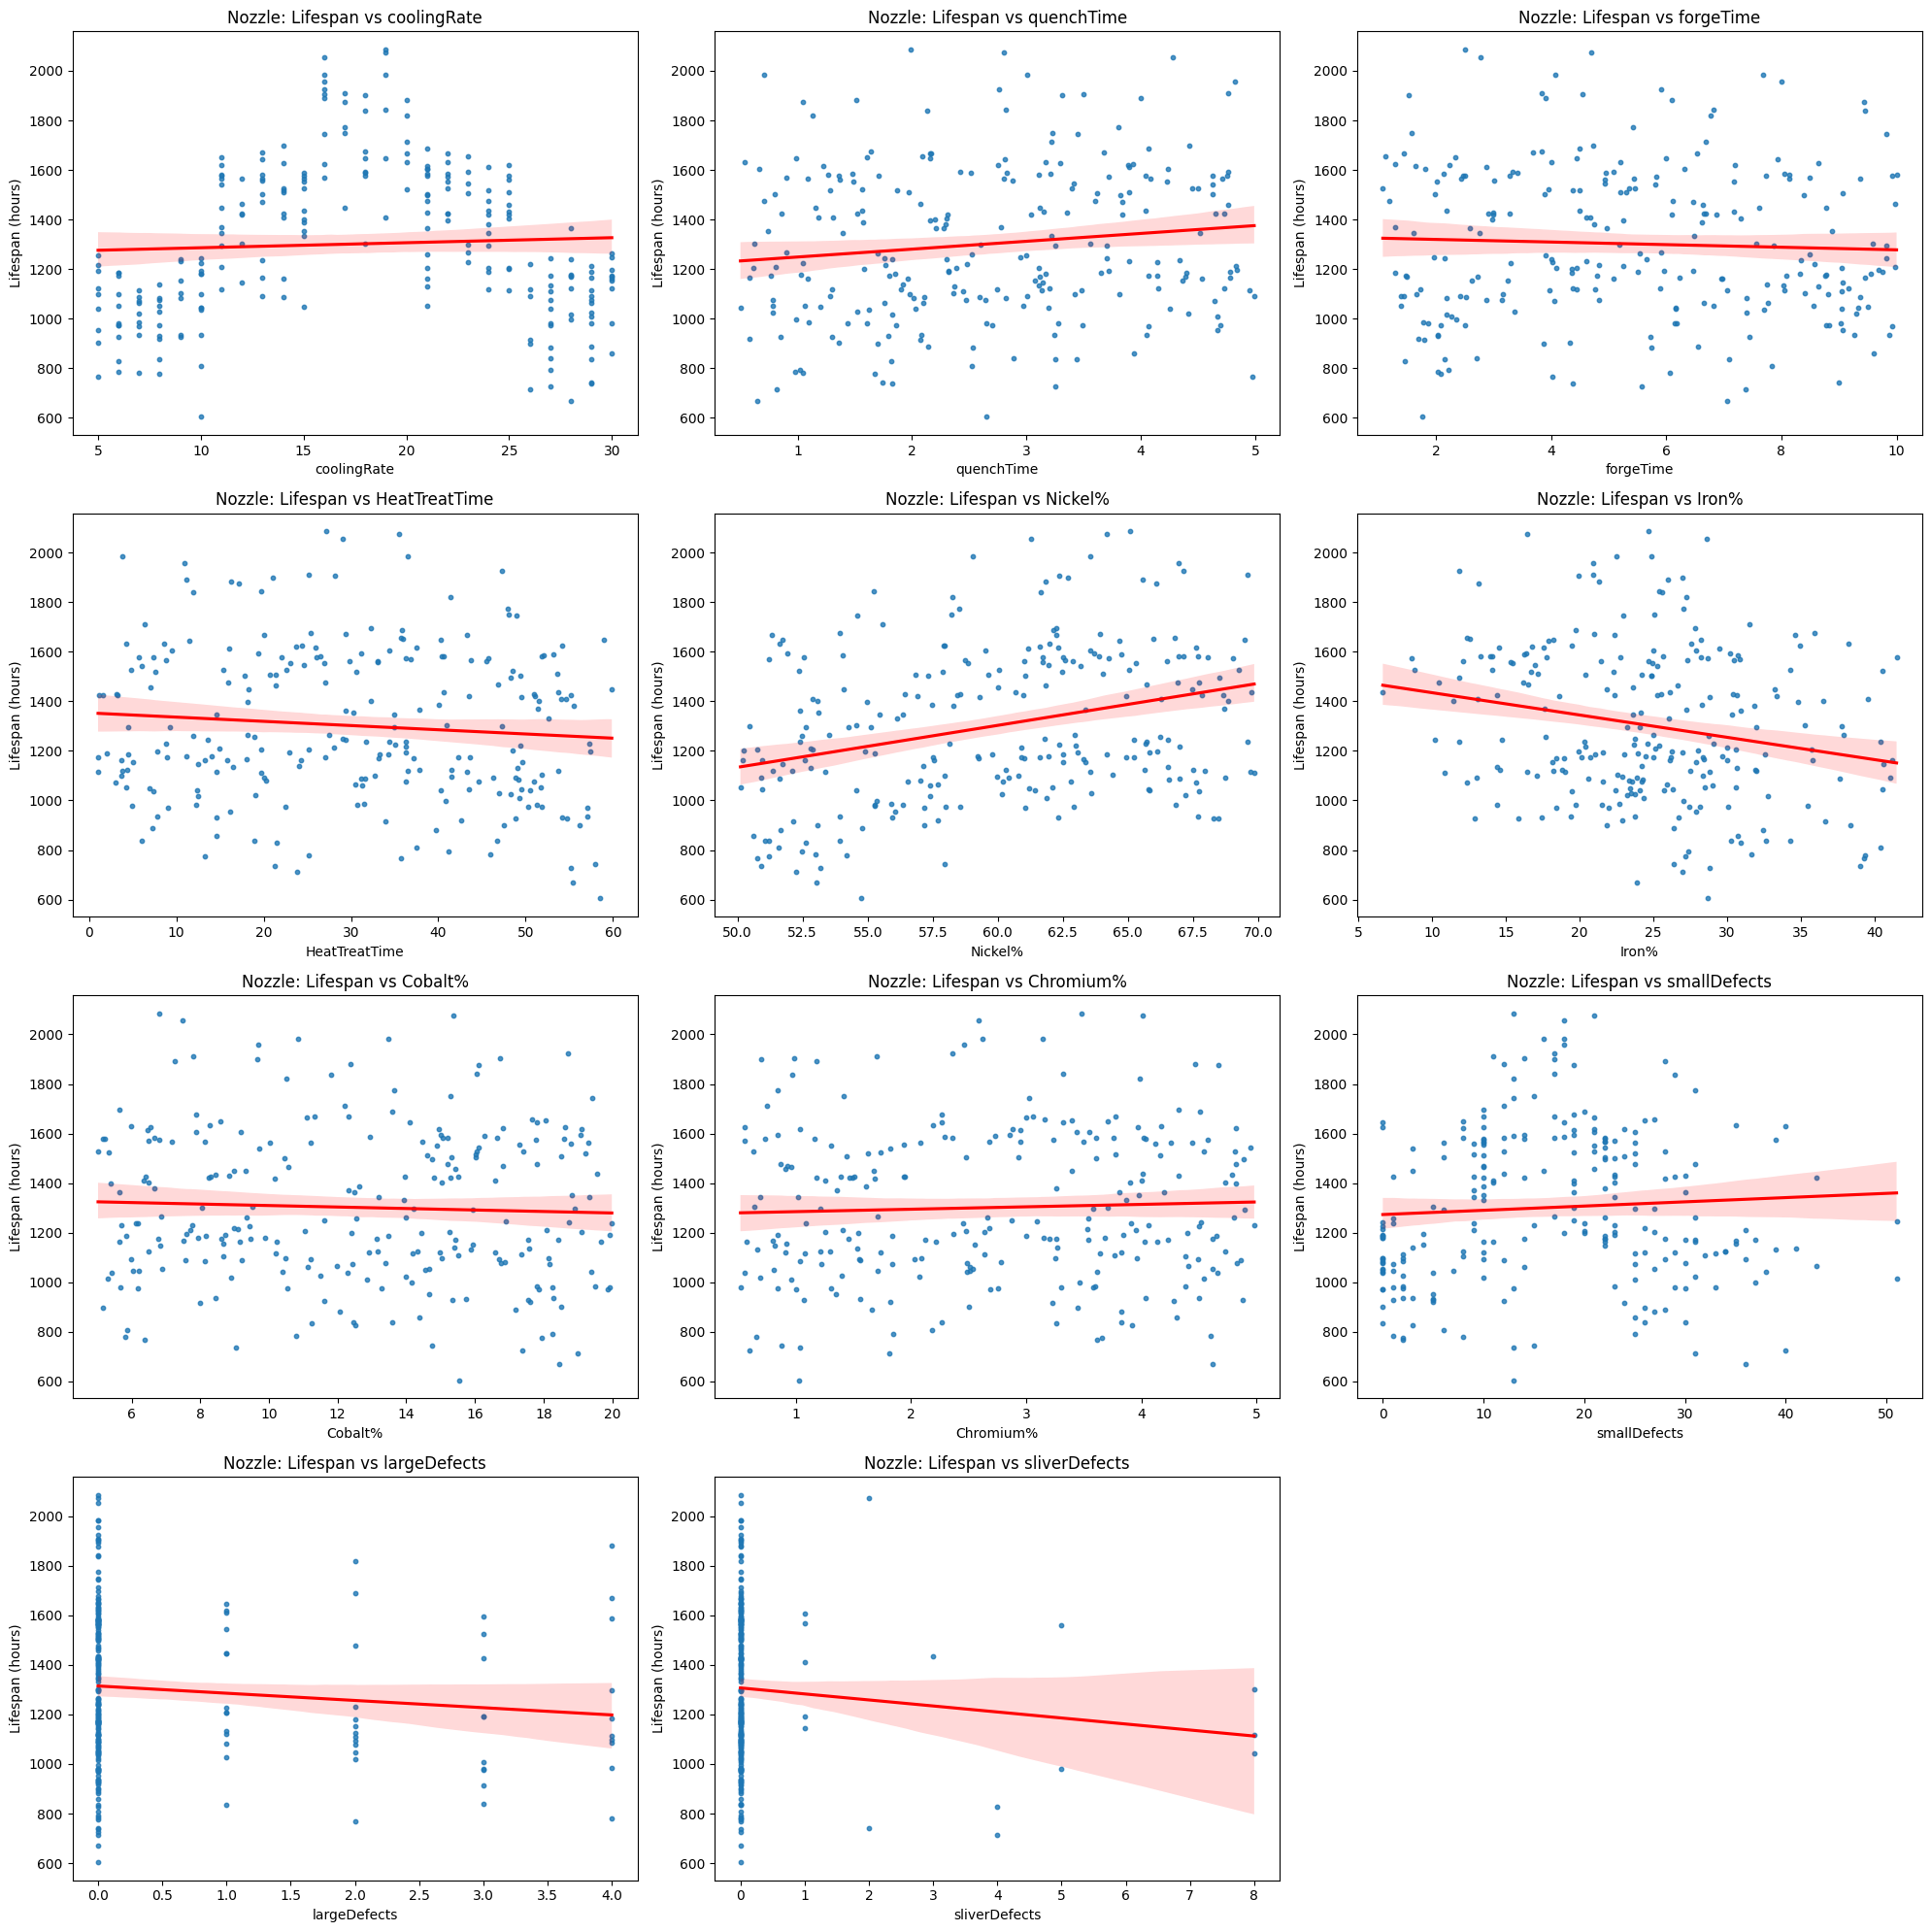

In [61]:
# 3. Scatter Plots for Nozzle
nozzle_data = df[df['partType'] == 'Nozzle']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=nozzle_data, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Nozzle: Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

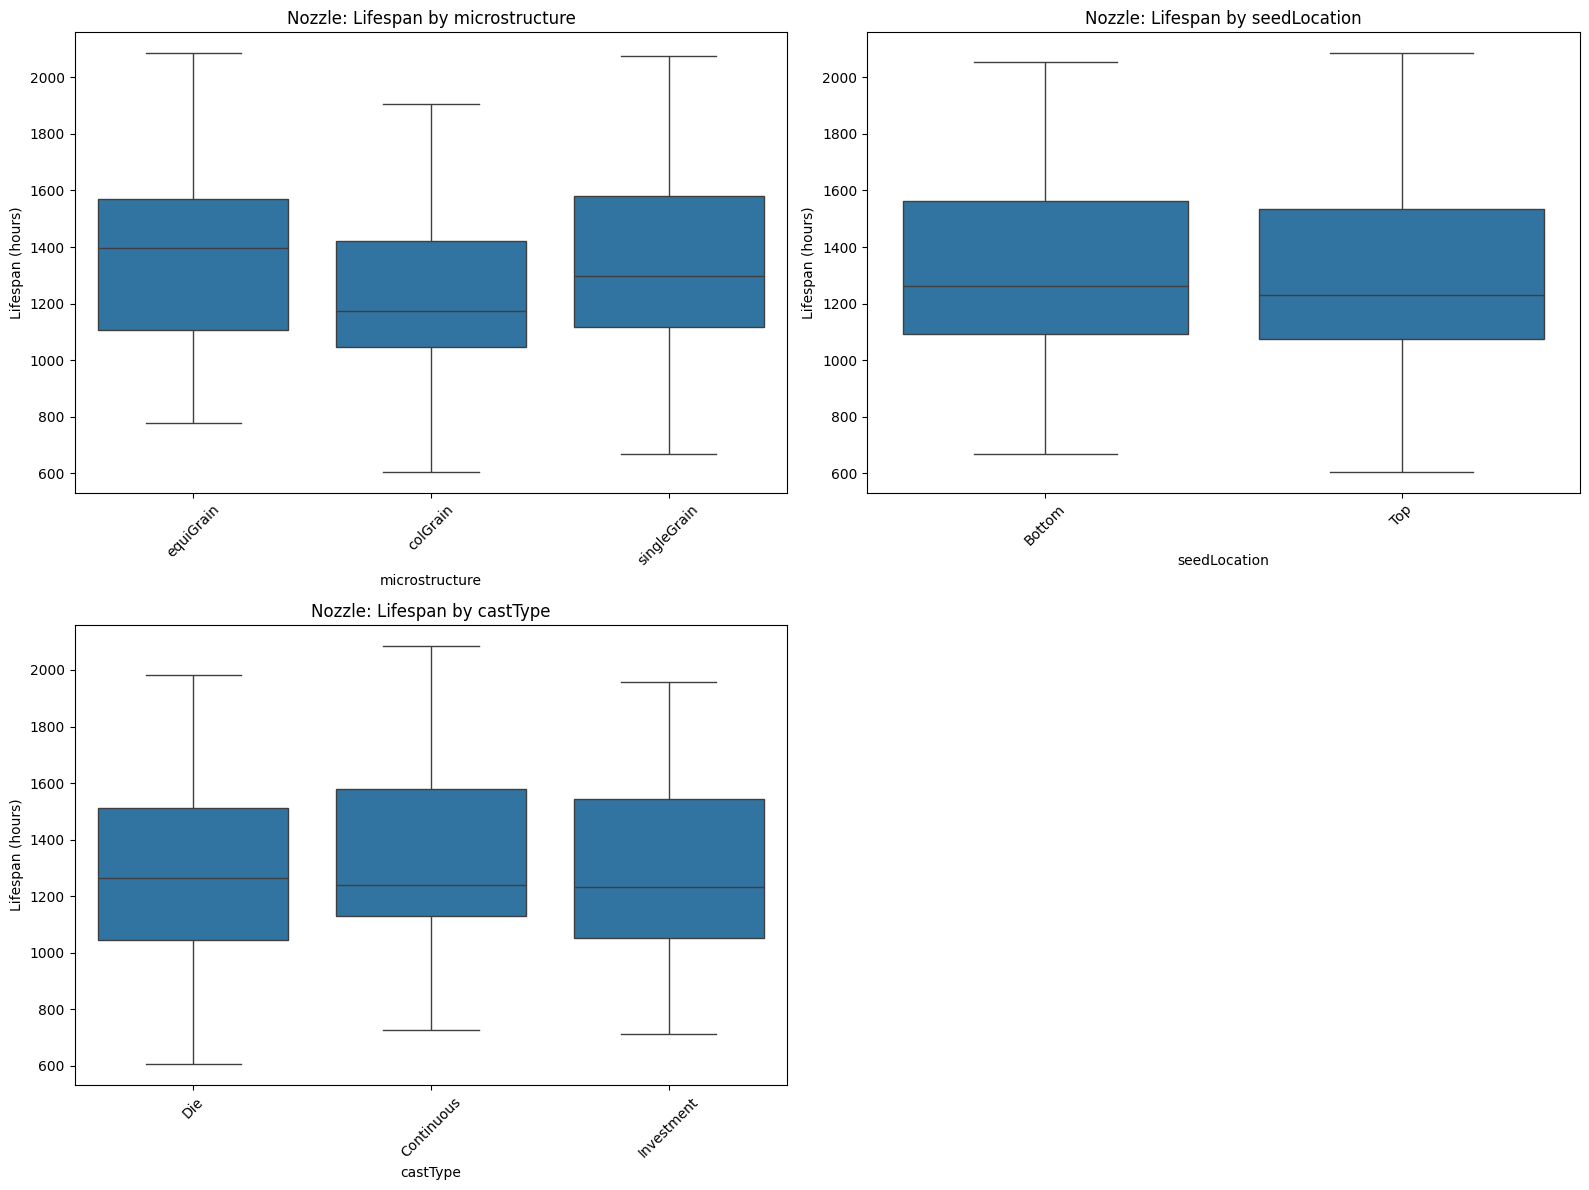

In [62]:
# 3. Box Plots for Nozzle
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(['microstructure', 'seedLocation', 'castType']):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=nozzle_data)
    axes[i].set_title(f'Nozzle: Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(['microstructure', 'seedLocation', 'castType']), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

---

### Blade

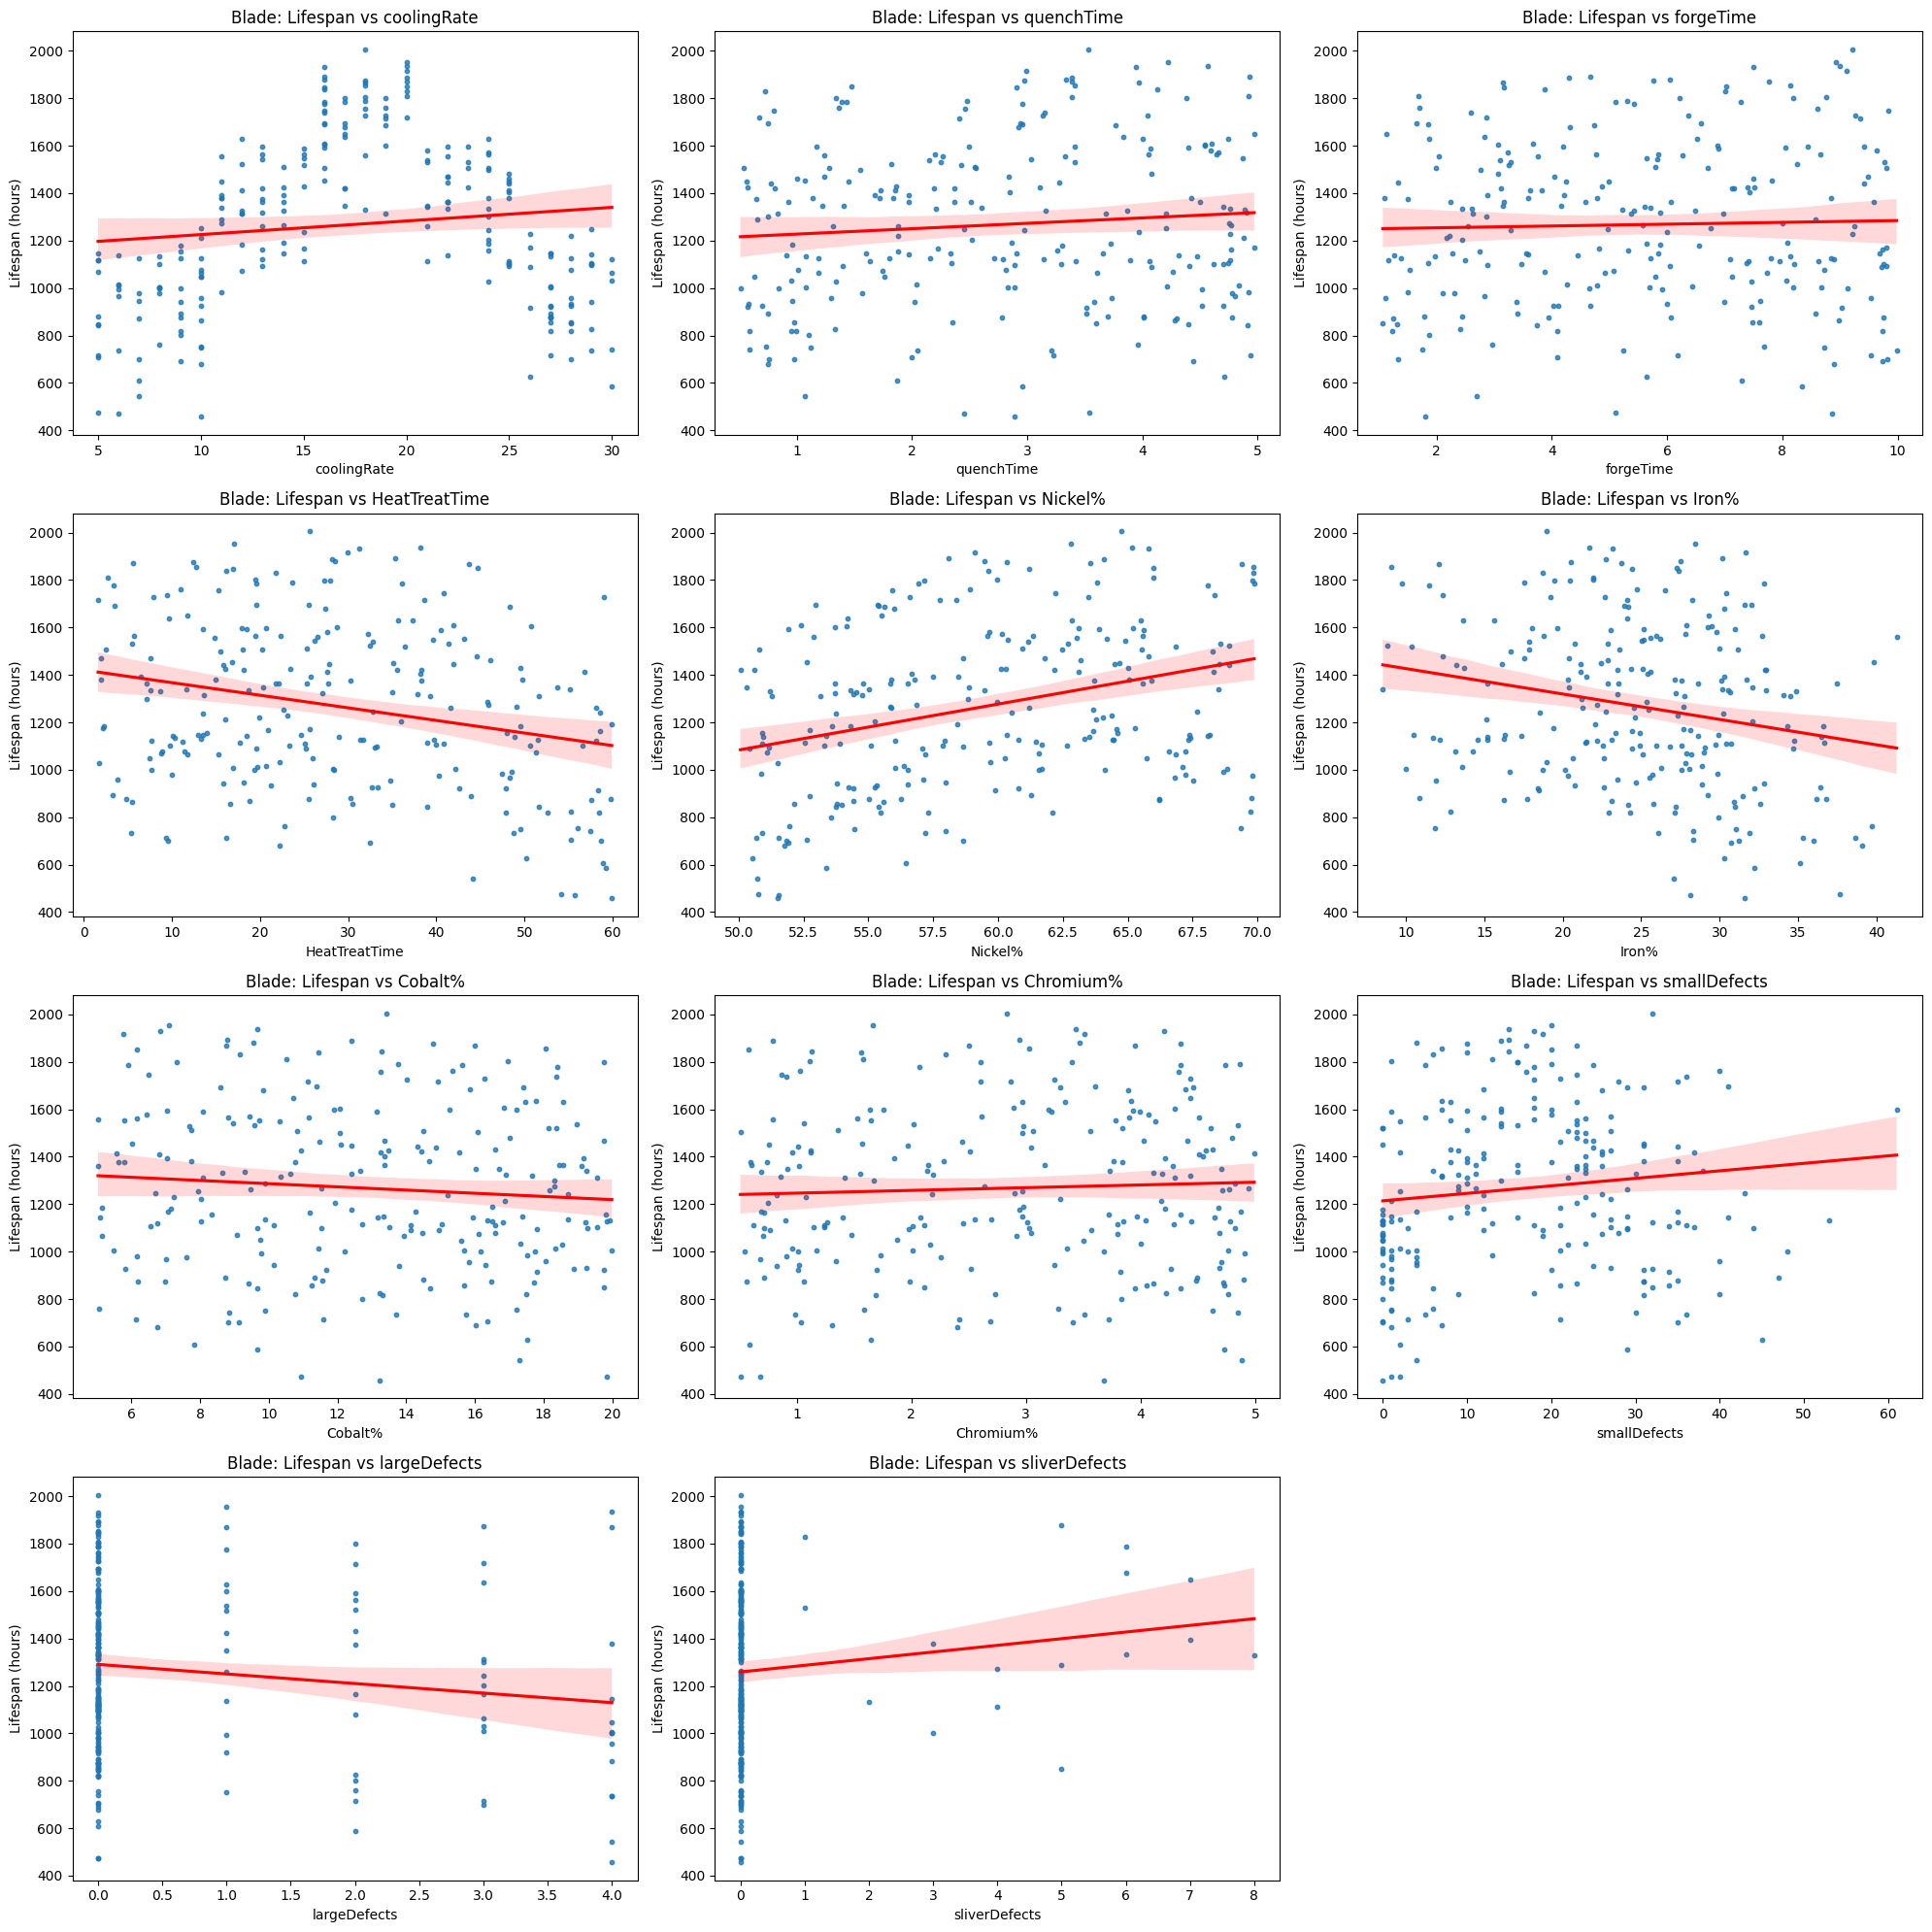

In [63]:
# 4. Scatter Plots for Blade
blade_data = df[df['partType'] == 'Blade']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numerical_cols):
    sns.regplot(ax=axes[i], data=blade_data, x=col, y='Lifespan', scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'Blade: Lifespan vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

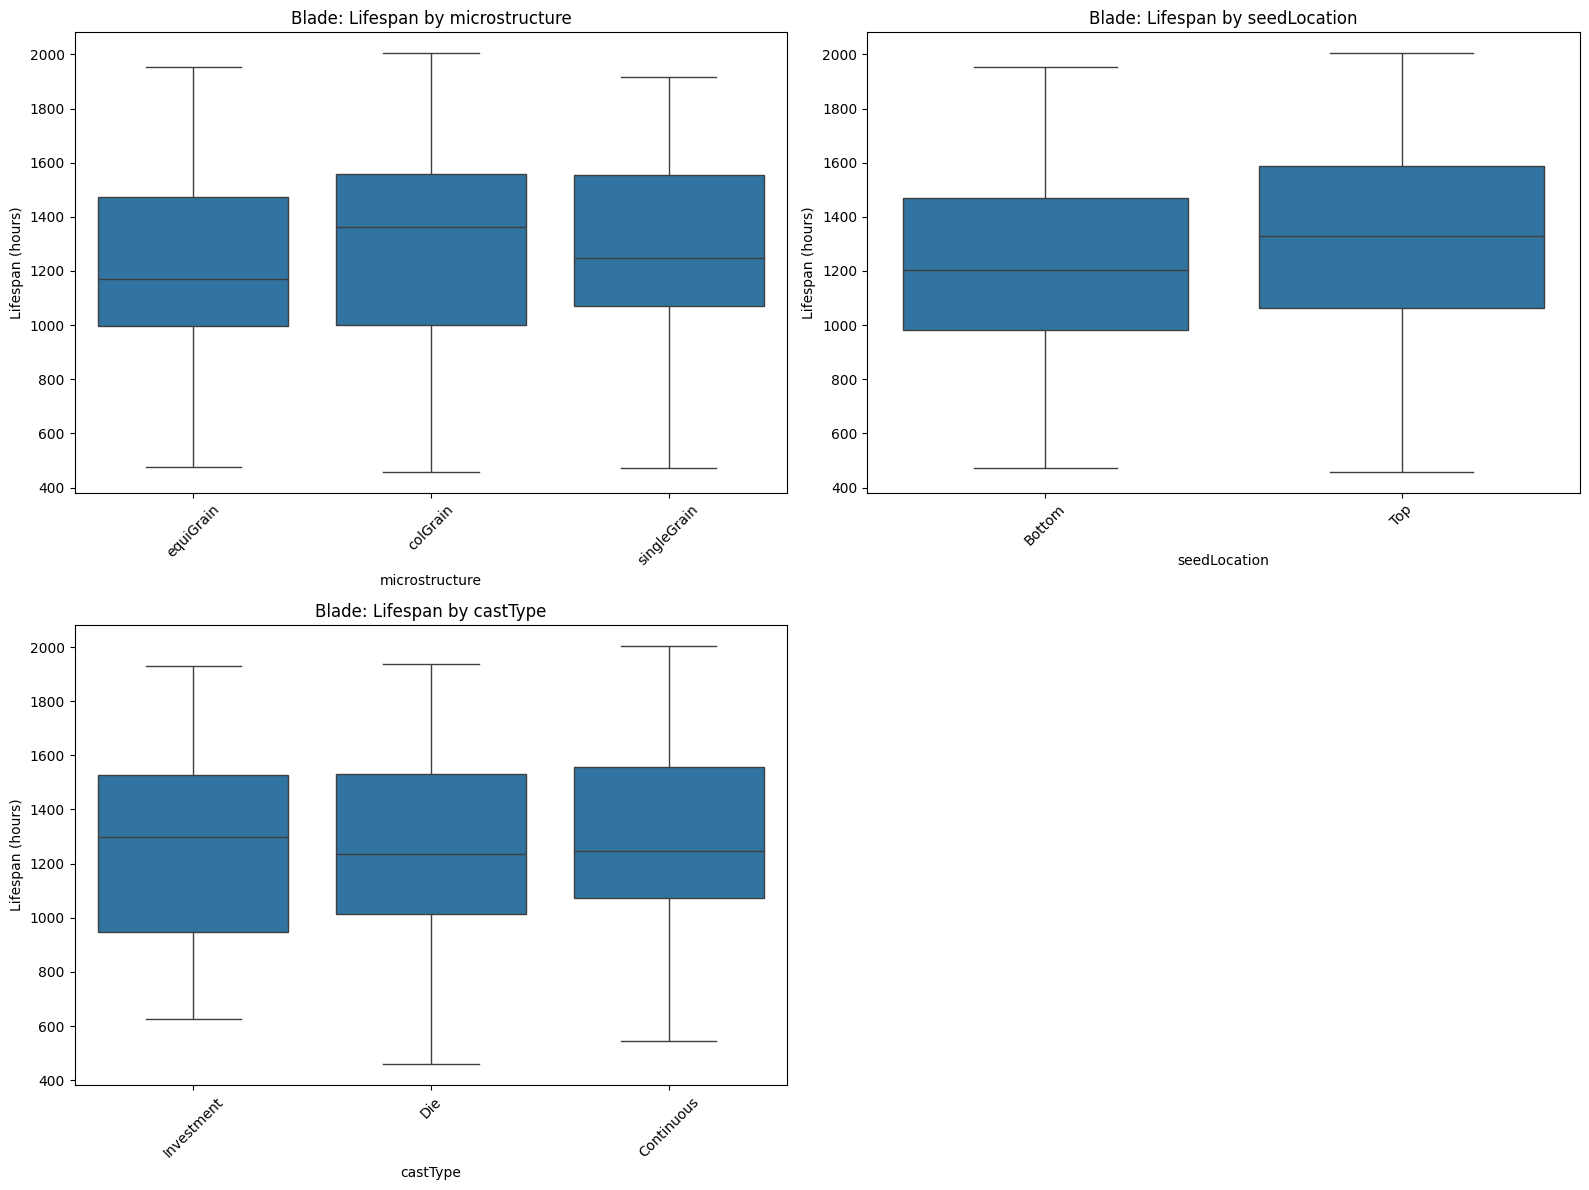

In [64]:
# 4. Box Plots for Blade
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(['microstructure', 'seedLocation', 'castType']):
    sns.boxplot(ax=axes[i], x=col, y='Lifespan', data=blade_data)
    axes[i].set_title(f'Blade: Lifespan by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Lifespan (hours)')
    axes[i].tick_params(axis='x', rotation=45)
for j in range(len(['microstructure', 'seedLocation', 'castType']), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

---

## Correlation Matrix for Combined Lifespan of Metal Parts

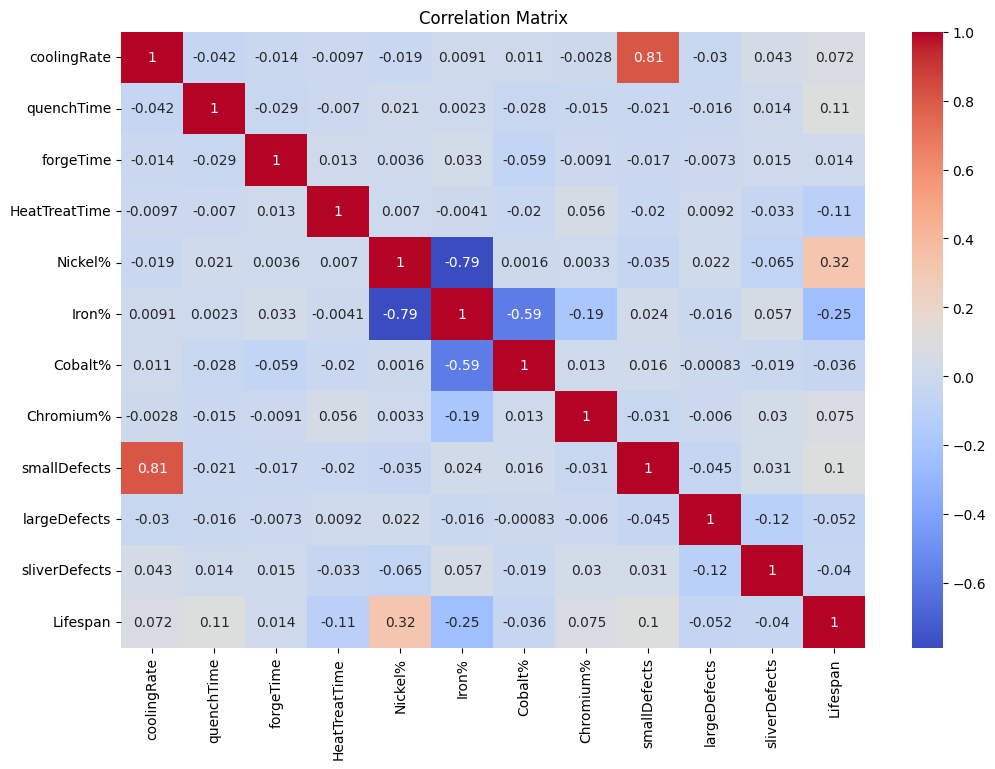

In [65]:
# Include 'Lifespan' in the correlation matrix
numerical_cols_with_target = numerical_cols + ['Lifespan']
corr_matrix = df[numerical_cols_with_target].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Correlation Matrix for Lifespan of Individual Metal Parts

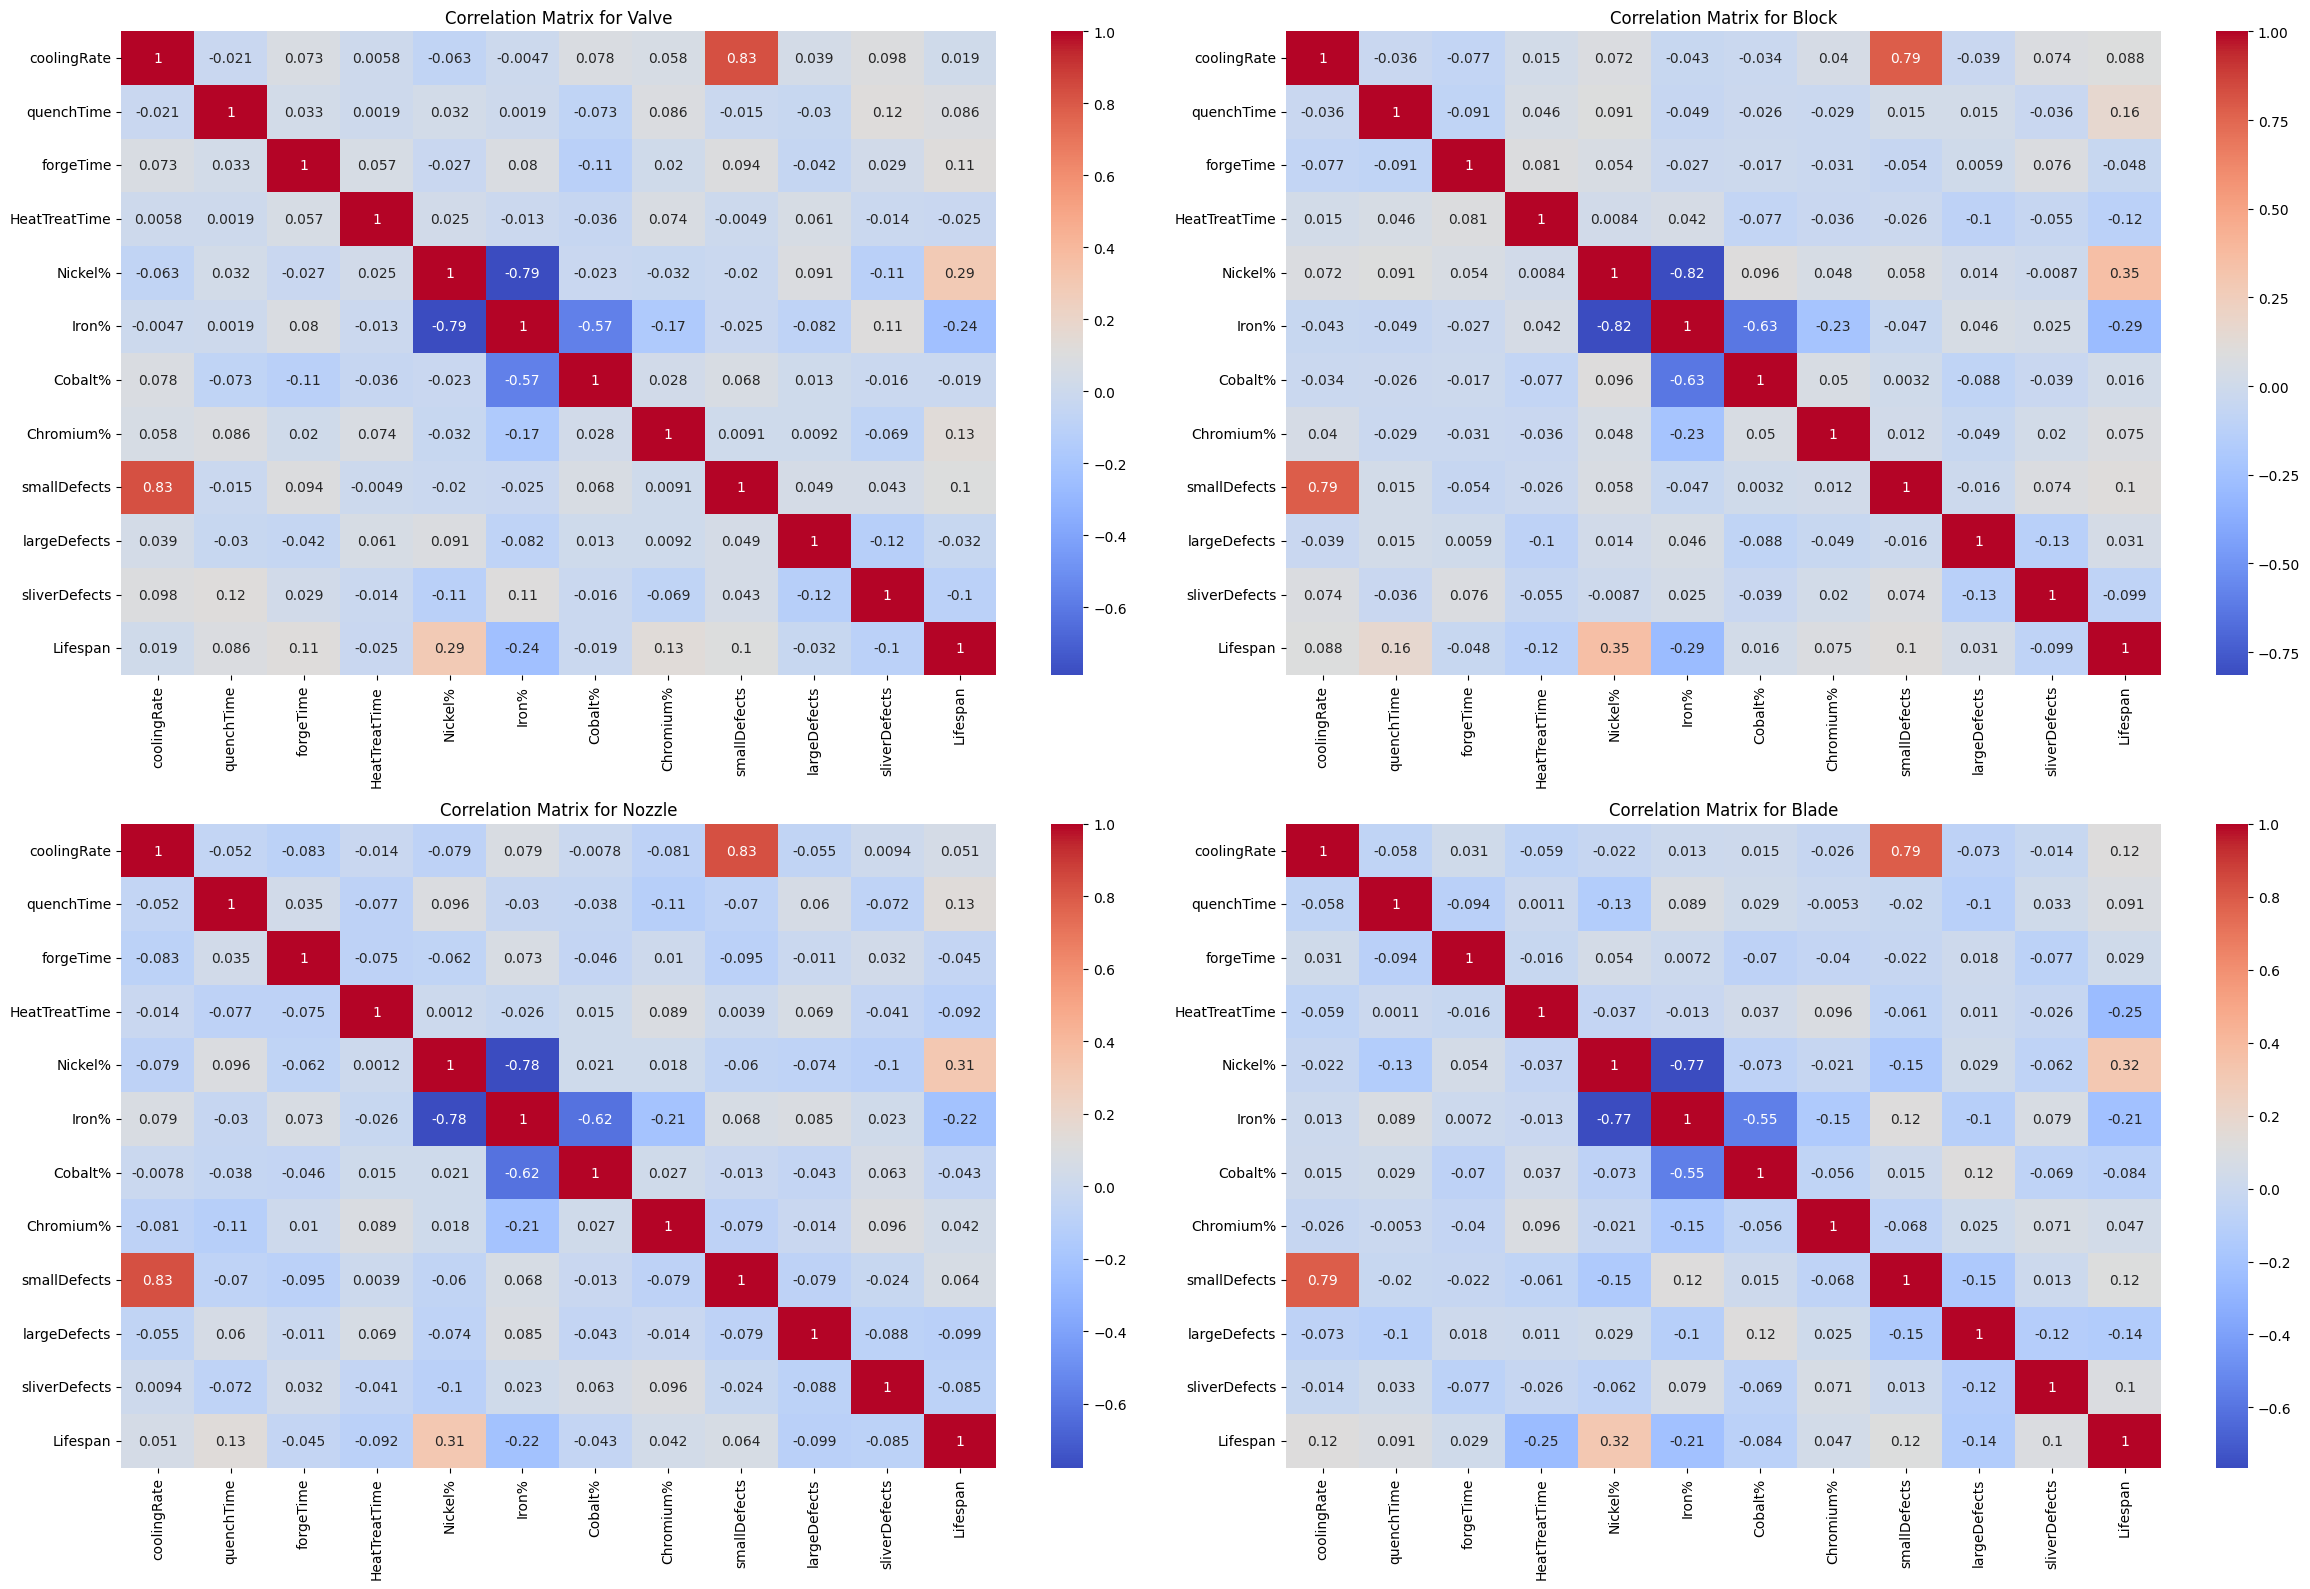

In [66]:
# Correlation Matrices for All Metal Parts in Subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 16))
axes = axes.flatten()

# 1. Correlation Matrix for Valve
valve_corr_matrix = valve_data[numerical_cols + ['Lifespan']].corr()
sns.heatmap(valve_corr_matrix, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix for Valve')

# 2. Correlation Matrix for Block
block_corr_matrix = block_data[numerical_cols + ['Lifespan']].corr()
sns.heatmap(block_corr_matrix, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix for Block')

# 3. Correlation Matrix for Nozzle
nozzle_corr_matrix = nozzle_data[numerical_cols + ['Lifespan']].corr()
sns.heatmap(nozzle_corr_matrix, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Correlation Matrix for Nozzle')

# 4. Correlation Matrix for Blade
blade_corr_matrix = blade_data[numerical_cols + ['Lifespan']].corr()
sns.heatmap(blade_corr_matrix, annot=True, cmap='coolwarm', ax=axes[3])
axes[3].set_title('Correlation Matrix for Blade')

plt.tight_layout()
plt.show()